In [2]:
import numpy, pandas
import conntility
import os
import connalysis
import tqdm

from scipy.spatial import distance
from matplotlib import pyplot as plt


In [3]:
# Connectivity matrix to use
fn_mat = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_NEWfunct_conmat_filtered_compressed.h5"
M = conntility.ConnectivityMatrix.from_h5(fn_mat)

## Patch sample and analysis helpers

Functions to patch sample and evaluate triads and connection probabilities

In [4]:
def partition_model_into_subvolumes(M, decomposition_plane, decomposition_sz, min_column_sz):
    grps = conntility.circuit_models.neuron_groups.group_by_grid(M.vertices, decomposition_plane, decomposition_sz)
    grps = grps.groupby("grid-subtarget")["node_ids"].apply(list)

    Ms = []
    for grp in grps:
        m = M.subpopulation(grp)
        if len(m) > min_column_sz:
            Ms.append(m)
    return Ms

In [38]:
col_slc = ["slice_x", "slice_y"]

def number_expected_er(P, N):
    from connalysis.network.topology import triad_combinations
    from scipy.stats import binom
    num_edge_per_triad = numpy.array([2, 2, 2, 3, 3, 3, 3, 4, 4 ,4 ,4, 5, 6])
    num_edge_per_non_triad = numpy.array([0, 1, 2])
    non_triad_combinations = numpy.array([1, 6, 3])

    p_er = triad_combinations * (P ** num_edge_per_triad) * ((1 - P) ** (6 - num_edge_per_triad))
    p_er_non = non_triad_combinations * (P ** num_edge_per_non_triad) * ((1 - P) ** (6 - num_edge_per_non_triad))
    assert numpy.abs(1 - (p_er.sum() + p_er_non.sum())) < 1E-6

    distr_er = binom(N, (p_er / p_er.sum()))
    return distr_er.mean(), distr_er.std()

def sample_and_count_triads(m, mv_cv, n_patch=12, n_samples=25, slice_thickness=150):
    counts = []
    sum_pairs = 0
    sum_connected = 0
    sum_rc = 0
    delta_rec = []
    delta_con = []
    delta_unc = []
    for _ in tqdm.tqdm(range(n_samples)):
        try:
            s = m.slice(numpy.random.rand() * numpy.pi, (numpy.random.rand() - 0.5) * 50, slice_thickness)
            s = s.patch_sample(n_patch, [0, 0], mv_cv, columns_xy=col_slc)
            sum_pairs += (len(s) * (len(s) - 1))
            sum_connected += s.matrix.nnz
            sum_rc += s.to_reciprocal().matrix.nnz
            counts.append(connalysis.network.topology.count_triads_fully_connected(s.matrix > 0, return_normalized=False))
            D = s.vertices[col_slc].values.reshape((-1, 1, 2)) - s.vertices[col_slc].values.reshape((1, -1, 2))
            delta_rec.append(pandas.DataFrame(
                D[(s.array > 0) & (s.array.transpose() > 0)], columns=["horizontal", "vertical"]
            ))
            delta_con.append(pandas.DataFrame(
                D[(s.array > 0) & (s.array.transpose() == 0)], columns=["horizontal", "vertical"]
            ))
            delta_unc.append(pandas.DataFrame(
                D[(s.array == 0)], columns=["horizontal", "vertical"]
            ))
        except:
            pass
    P = sum_connected / sum_pairs
    Prec = sum_rc / sum_pairs
    deltas = pandas.concat([
        pandas.concat(delta_rec, axis=0, names=["sample"], keys=range(len(delta_rec))),
        pandas.concat(delta_con, axis=0, names=["sample"], keys=range(len(delta_con))),
        pandas.concat(delta_unc, axis=0, names=["sample"], keys=range(len(delta_unc)))
    ], axis=0, keys=["reciprocal", "connected", "unconnected"])
    counts = numpy.vstack(counts).sum(axis=0)
    return counts, (P, Prec), deltas


Main entry point

In [50]:
def execute_slice_and_patch_campaign(M, param_dict):
    if "decomposition_plane" in param_dict:
        Ms = partition_model_into_subvolumes(M, param_dict["decomposition_plane"],
                                             param_dict["decomposition_sz"], param_dict["min_column_sz"])
    else:
        Ms = [M]
    
    all_counts = []
    all_er = []
    all_deltas = []

    mv_cv = numpy.array(param_dict["mv_cv"])
    patch_kwargs = param_dict["patch_kwargs"]
    allP_u = []; allP_rc = []
    for m in Ms:
        counts, P, deltas = sample_and_count_triads(m, mv_cv, **patch_kwargs)
        allP_u.append(P[0]); allP_rc.append(P[1])
        count_er_mn, count_er_sd = number_expected_er(P[0], counts.sum())
        all_counts.append((counts - count_er_mn) / count_er_sd)
        all_deltas.append(deltas)

    all_counts = pandas.DataFrame(all_counts,
                     index=pandas.RangeIndex(len(all_counts), name="subvolume"),
                     columns=pandas.RangeIndex(13, name="motif"))
    all_deltas = pandas.concat(all_deltas, axis=0, names=["subvolume"], keys=range(len(all_deltas)))
    return all_counts, all_deltas, pandas.DataFrame({"unidirectional": allP_u,
                                                     "reciprocal": allP_rc})
    

## EXECUTE!

### Part I: Triad motifs for a realistic sampling
Note: If you are only interested in part II, you can skip execution of this part.

In [51]:
campaign_cfg = {
    "decomposition_plane": ["x", "z"], # What are the horizontal axes of the volume?Decomposition will happen in this plane.
    "decomposition_sz": 200,
    "min_column_sz": 500, # After decomposition, columns smaller than this will be discarded,
    "mv_cv": [[40**2, 0], [0, 40**2]], # Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
    "patch_kwargs": {
        "slice_thickness": 150,
        "n_samples": 25, # The number of times the patch sampling procedure will be applied
        "n_patch": 12 # Up to this number of neurons will be sampled together
    }
}

all_counts, all_deltas, P = execute_slice_and_patch_campaign(M, campaign_cfg)

 12%|█▏        | 3/25 [00:00<00:00, 22.49it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013875961303710938
Found 179 connected triads
Time spent classifying triads: 0.01418447494506836
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009458065032958984
Found 42 connected triads
Time spent classifying triads: 0.001737356185913086
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007605552673339844
Found 15 connected triads
Time spent classifying triads: 0.0007004737854003906
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012965202331542969
Found 183 connected triads
Time spent classifying triads: 0.007338762283325195
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010561943054199219
Found 82 connected triads
Time spent classifying triads: 0.0033197402954101562


 36%|███▌      | 9/25 [00:00<00:00, 22.54it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001157999038696289
Found 111 connected triads
Time spent classifying triads: 0.010465145111083984
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011625289916992188
Found 85 connected triads
Time spent classifying triads: 0.0034193992614746094
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011758804321289062
Found 80 connected triads
Time spent classifying triads: 0.0032596588134765625
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012865066528320312
Found 149 connected triads
Time spent classifying triads: 0.0060694217681884766
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009167194366455078
Found 47 connected triads
Time spent classifying triads: 0.0019385814666748047


 60%|██████    | 15/25 [00:00<00:00, 23.05it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012977123260498047
Found 165 connected triads
Time spent classifying triads: 0.01551365852355957
Testing 52 potential triadic pairs
Time spent finding triads: 0.001003265380859375
Found 57 connected triads
Time spent classifying triads: 0.0023632049560546875
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010957717895507812
Found 117 connected triads
Time spent classifying triads: 0.004682779312133789
Testing 44 potential triadic pairs
Time spent finding triads: 0.00099945068359375
Found 80 connected triads
Time spent classifying triads: 0.003221750259399414
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011186599731445312
Found 113 connected triads
Time spent classifying triads: 0.004551410675048828


 72%|███████▏  | 18/25 [00:00<00:00, 22.96it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0014910697937011719
Found 57 connected triads
Time spent classifying triads: 0.0054280757904052734
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010237693786621094
Found 68 connected triads
Time spent classifying triads: 0.0027532577514648438
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011267662048339844
Found 101 connected triads
Time spent classifying triads: 0.004048585891723633
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008237361907958984
Found 23 connected triads
Time spent classifying triads: 0.0010082721710205078
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010695457458496094
Found 91 connected triads
Time spent classifying triads: 0.0036334991455078125
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009303092956542969
Found 37 connected triads
Time spent classifying triads: 0.0035614967346191406


100%|██████████| 25/25 [00:01<00:00, 22.86it/s]


Testing 61 potential triadic pairs
Time spent finding triads: 0.001155853271484375
Found 106 connected triads
Time spent classifying triads: 0.009954452514648438
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012161731719970703
Found 153 connected triads
Time spent classifying triads: 0.006082296371459961
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011584758758544922
Found 127 connected triads
Time spent classifying triads: 0.005110979080200195
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008542537689208984
Found 27 connected triads
Time spent classifying triads: 0.0011639595031738281


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0010957717895507812
Found 86 connected triads
Time spent classifying triads: 0.007896900177001953


 12%|█▏        | 3/25 [00:00<00:01, 21.31it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011153221130371094
Found 89 connected triads
Time spent classifying triads: 0.008343696594238281
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011916160583496094
Found 139 connected triads
Time spent classifying triads: 0.00552821159362793
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012061595916748047
Found 150 connected triads
Time spent classifying triads: 0.0060651302337646484
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011751651763916016
Found 133 connected triads
Time spent classifying triads: 0.005261898040771484


 24%|██▍       | 6/25 [00:00<00:00, 21.27it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012359619140625
Found 145 connected triads
Time spent classifying triads: 0.013520956039428711


 36%|███▌      | 9/25 [00:00<00:00, 22.57it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0011816024780273438
Found 105 connected triads
Time spent classifying triads: 0.005509138107299805
Testing 56 potential triadic pairs
Time spent finding triads: 0.00099945068359375
Found 62 connected triads
Time spent classifying triads: 0.002518892288208008
Testing 47 potential triadic pairs
Time spent finding triads: 0.0009927749633789062
Found 67 connected triads
Time spent classifying triads: 0.002730131149291992
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009000301361083984
Found 36 connected triads
Time spent classifying triads: 0.0015094280242919922
Testing 65 potential triadic pairs
Time spent finding triads: 0.00115966796875
Found 129 connected triads
Time spent classifying triads: 0.011658668518066406


 60%|██████    | 15/25 [00:00<00:00, 22.73it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012688636779785156
Found 165 connected triads
Time spent classifying triads: 0.015050172805786133
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010373592376708984
Found 76 connected triads
Time spent classifying triads: 0.003102540969848633
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008296966552734375
Found 26 connected triads
Time spent classifying triads: 0.0011141300201416016
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011479854583740234
Found 122 connected triads
Time spent classifying triads: 0.004850625991821289
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008809566497802734
Found 25 connected triads
Time spent classifying triads: 0.0024433135986328125
Testing 66 potential triadic pairs
Time spent finding triads: 0.001178741455078125
Found 143 connected triads


 72%|███████▏  | 18/25 [00:00<00:00, 22.54it/s]

Time spent classifying triads: 0.013532638549804688
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010592937469482422
Found 89 connected triads
Time spent classifying triads: 0.0035724639892578125
Testing 65 potential triadic pairs
Time spent finding triads: 0.001184225082397461
Found 131 connected triads
Time spent classifying triads: 0.0052776336669921875
Testing 59 potential triadic pairs
Time spent finding triads: 0.0010678768157958984
Found 94 connected triads
Time spent classifying triads: 0.0038022994995117188


 84%|████████▍ | 21/25 [00:00<00:00, 23.05it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 15 connected triads
Time spent classifying triads: 0.001504659652709961
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009205341339111328
Found 26 connected triads
Time spent classifying triads: 0.0011343955993652344


100%|██████████| 25/25 [00:01<00:00, 22.73it/s]


Testing 41 potential triadic pairs
Time spent finding triads: 0.0009598731994628906
Found 47 connected triads
Time spent classifying triads: 0.004494905471801758
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012433528900146484
Found 170 connected triads
Time spent classifying triads: 0.006789207458496094
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009028911590576172
Found 47 connected triads
Time spent classifying triads: 0.0019412040710449219


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0011763572692871094
Found 120 connected triads
Time spent classifying triads: 0.011256933212280273
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011751651763916016
Found 135 connected triads
Time spent classifying triads: 0.0053899288177490234


 12%|█▏        | 3/25 [00:00<00:01, 21.21it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001211404800415039
Found 133 connected triads
Time spent classifying triads: 0.01248788833618164
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011737346649169922
Found 134 connected triads
Time spent classifying triads: 0.005349636077880859
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009419918060302734
Found 47 connected triads
Time spent classifying triads: 0.0019421577453613281


 24%|██▍       | 6/25 [00:00<00:00, 21.88it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012629032135009766
Found 159 connected triads
Time spent classifying triads: 0.015212297439575195
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011794567108154297
Found 149 connected triads
Time spent classifying triads: 0.00594782829284668


 36%|███▌      | 9/25 [00:00<00:00, 21.80it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012547969818115234
Found 154 connected triads
Time spent classifying triads: 0.014468908309936523
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012137889862060547
Found 162 connected triads
Time spent classifying triads: 0.006438732147216797
Testing 65 potential triadic pairs
Time spent finding triads: 0.001150369644165039
Found 129 connected triads
Time spent classifying triads: 0.005109071731567383


 48%|████▊     | 12/25 [00:00<00:00, 22.43it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001253366470336914
Found 159 connected triads
Time spent classifying triads: 0.007014036178588867
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012099742889404297
Found 161 connected triads
Time spent classifying triads: 0.006380796432495117


 60%|██████    | 15/25 [00:00<00:00, 22.53it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012462139129638672
Found 97 connected triads
Time spent classifying triads: 0.009094476699829102
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011947154998779297
Found 143 connected triads
Time spent classifying triads: 0.005688667297363281
Testing 66 potential triadic pairs
Time spent finding triads: 0.001184225082397461
Found 147 connected triads
Time spent classifying triads: 0.005845546722412109
Testing 48 potential triadic pairs
Time spent finding triads: 0.001012563705444336
Found 54 connected triads
Time spent classifying triads: 0.005154609680175781
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012116432189941406
Found 144 connected triads
Time spent classifying triads: 0.005754232406616211


 72%|███████▏  | 18/25 [00:00<00:00, 22.69it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0017304420471191406
Found 91 connected triads
Time spent classifying triads: 0.006600141525268555
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012176036834716797
Found 153 connected triads
Time spent classifying triads: 0.006104707717895508
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010678768157958984
Found 96 connected triads
Time spent classifying triads: 0.003858327865600586


 84%|████████▍ | 21/25 [00:00<00:00, 23.04it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0015256404876708984
Found 56 connected triads
Time spent classifying triads: 0.005187273025512695
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012426376342773438
Found 169 connected triads
Time spent classifying triads: 0.006701231002807617


100%|██████████| 25/25 [00:01<00:00, 22.51it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.001249551773071289
Found 158 connected triads
Time spent classifying triads: 0.014807939529418945
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012590885162353516
Found 171 connected triads
Time spent classifying triads: 0.006762266159057617
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011224746704101562
Found 111 connected triads
Time spent classifying triads: 0.004463672637939453


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012056827545166016
Found 134 connected triads
Time spent classifying triads: 0.012599468231201172
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011868476867675781
Found 144 connected triads
Time spent classifying triads: 0.006223201751708984


 20%|██        | 5/25 [00:00<00:00, 21.52it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012464523315429688
Found 147 connected triads
Time spent classifying triads: 0.006970405578613281
Testing 39 potential triadic pairs
Time spent finding triads: 0.0010287761688232422
Found 47 connected triads
Time spent classifying triads: 0.001961231231689453
Testing 33 potential triadic pairs
Time spent finding triads: 0.000896453857421875
Found 42 connected triads
Time spent classifying triads: 0.0017888545989990234
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012288093566894531
Found 152 connected triads
Time spent classifying triads: 0.013394832611083984
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007266998291015625
Found 5 connected triads
Time spent classifying triads: 0.0002918243408203125


 32%|███▏      | 8/25 [00:00<00:00, 21.40it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 18 connected triads
Time spent classifying triads: 0.001791238784790039
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010242462158203125
Found 73 connected triads
Time spent classifying triads: 0.002935171127319336
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010416507720947266
Found 96 connected triads
Time spent classifying triads: 0.0038356781005859375


 44%|████▍     | 11/25 [00:00<00:00, 22.08it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0012650489807128906
Found 76 connected triads
Time spent classifying triads: 0.0055065155029296875
Testing 48 potential triadic pairs
Time spent finding triads: 0.0009799003601074219
Found 55 connected triads
Time spent classifying triads: 0.0022704601287841797


 56%|█████▌    | 14/25 [00:00<00:00, 21.94it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012979507446289062
Found 177 connected triads
Time spent classifying triads: 0.010843276977539062
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010333061218261719
Found 74 connected triads
Time spent classifying triads: 0.0030298233032226562
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010137557983398438
Found 66 connected triads
Time spent classifying triads: 0.0026726722717285156


 68%|██████▊   | 17/25 [00:00<00:00, 21.33it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013241767883300781
Found 179 connected triads
Time spent classifying triads: 0.016831159591674805
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011792182922363281
Found 134 connected triads
Time spent classifying triads: 0.0063266754150390625


 80%|████████  | 20/25 [00:00<00:00, 21.11it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012974739074707031
Found 175 connected triads
Time spent classifying triads: 0.01645970344543457
Testing 16 potential triadic pairs
Time spent finding triads: 0.0007762908935546875
Found 14 connected triads
Time spent classifying triads: 0.0006465911865234375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012547969818115234
Found 169 connected triads
Time spent classifying triads: 0.006691455841064453
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012891292572021484
Found 172 connected triads
Time spent classifying triads: 0.016180753707885742
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010073184967041016
Found 70 connected triads
Time spent classifying triads: 0.0028650760650634766


100%|██████████| 25/25 [00:01<00:00, 21.27it/s]


Testing 47 potential triadic pairs
Time spent finding triads: 0.0010342597961425781
Found 54 connected triads
Time spent classifying triads: 0.005154848098754883
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011601448059082031
Found 123 connected triads
Time spent classifying triads: 0.004945516586303711
Testing 49 potential triadic pairs
Time spent finding triads: 0.0009670257568359375
Found 50 connected triads
Time spent classifying triads: 0.0020384788513183594


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0011930465698242188
Found 111 connected triads
Time spent classifying triads: 0.010459423065185547


 16%|█▌        | 4/25 [00:00<00:01, 18.41it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010418891906738281
Found 66 connected triads
Time spent classifying triads: 0.006301403045654297
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012021064758300781
Found 134 connected triads
Time spent classifying triads: 0.005355358123779297
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012099742889404297
Found 142 connected triads
Time spent classifying triads: 0.005685329437255859
Testing 64 potential triadic pairs
Time spent finding triads: 0.0013515949249267578
Found 128 connected triads
Time spent classifying triads: 0.012036561965942383


 32%|███▏      | 8/25 [00:00<00:00, 17.82it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012936592102050781
Found 174 connected triads
Time spent classifying triads: 0.01634073257446289
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012524127960205078
Found 179 connected triads
Time spent classifying triads: 0.007165193557739258
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011551380157470703
Found 118 connected triads
Time spent classifying triads: 0.004752635955810547
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011608600616455078
Found 115 connected triads
Time spent classifying triads: 0.010846853256225586


 48%|████▊     | 12/25 [00:00<00:00, 18.33it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011472702026367188
Found 96 connected triads
Time spent classifying triads: 0.00907588005065918
Testing 34 potential triadic pairs
Time spent finding triads: 0.0008904933929443359
Found 32 connected triads
Time spent classifying triads: 0.0013573169708251953
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011491775512695312
Found 124 connected triads
Time spent classifying triads: 0.0049359798431396484
Testing 66 potential triadic pairs
Time spent finding triads: 0.0026319026947021484
Found 168 connected triads
Time spent classifying triads: 0.01583242416381836


 64%|██████▍   | 16/25 [00:00<00:00, 18.06it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001271963119506836
Found 156 connected triads
Time spent classifying triads: 0.01466226577758789
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009438991546630859
Found 49 connected triads
Time spent classifying triads: 0.0020134449005126953
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011401176452636719
Found 109 connected triads
Time spent classifying triads: 0.004344463348388672
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012493133544921875
Found 152 connected triads
Time spent classifying triads: 0.013255119323730469


 80%|████████  | 20/25 [00:01<00:00, 18.21it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0009572505950927734
Found 43 connected triads
Time spent classifying triads: 0.004128932952880859
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012891292572021484
Found 170 connected triads
Time spent classifying triads: 0.009340286254882812
Testing 53 potential triadic pairs
Time spent finding triads: 0.001008749008178711
Found 57 connected triads
Time spent classifying triads: 0.0023534297943115234
Testing 66 potential triadic pairs
Time spent finding triads: 0.002117156982421875
Found 156 connected triads
Time spent classifying triads: 0.006944179534912109


 96%|█████████▌| 24/25 [00:01<00:00, 18.82it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008404254913330078
Found 15 connected triads
Time spent classifying triads: 0.0015163421630859375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012021064758300781
Found 129 connected triads
Time spent classifying triads: 0.0051229000091552734
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009229183197021484
Found 46 connected triads
Time spent classifying triads: 0.0031812191009521484


100%|██████████| 25/25 [00:01<00:00, 18.13it/s]


Testing 51 potential triadic pairs
Time spent finding triads: 0.0016121864318847656
Found 65 connected triads
Time spent classifying triads: 0.0060672760009765625


  8%|▊         | 2/25 [00:00<00:01, 18.48it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0011243820190429688
Found 85 connected triads
Time spent classifying triads: 0.008067131042480469
Testing 56 potential triadic pairs
Time spent finding triads: 0.00109100341796875
Found 91 connected triads
Time spent classifying triads: 0.003634214401245117
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010139942169189453
Found 74 connected triads
Time spent classifying triads: 0.0029904842376708984


 16%|█▌        | 4/25 [00:00<00:01, 17.65it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001354217529296875
Found 174 connected triads
Time spent classifying triads: 0.015397071838378906


 24%|██▍       | 6/25 [00:00<00:01, 18.18it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010433197021484375
Found 58 connected triads
Time spent classifying triads: 0.003857851028442383
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011539459228515625
Found 111 connected triads
Time spent classifying triads: 0.004429817199707031
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012459754943847656
Found 170 connected triads
Time spent classifying triads: 0.0066988468170166016


 32%|███▏      | 8/25 [00:00<00:00, 18.08it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012288093566894531
Found 135 connected triads
Time spent classifying triads: 0.0070798397064208984


 40%|████      | 10/25 [00:00<00:00, 18.31it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009355545043945312
Found 38 connected triads
Time spent classifying triads: 0.003652811050415039
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012083053588867188
Found 161 connected triads
Time spent classifying triads: 0.00639653205871582
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012807846069335938
Found 172 connected triads
Time spent classifying triads: 0.006876707077026367


 48%|████▊     | 12/25 [00:00<00:00, 17.84it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012564659118652344
Found 140 connected triads
Time spent classifying triads: 0.013191461563110352


 56%|█████▌    | 14/25 [00:00<00:00, 17.86it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001270294189453125
Found 156 connected triads
Time spent classifying triads: 0.008992195129394531
Testing 65 potential triadic pairs
Time spent finding triads: 0.001199960708618164
Found 141 connected triads
Time spent classifying triads: 0.005665302276611328
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 27 connected triads
Time spent classifying triads: 0.0011510848999023438


 64%|██████▍   | 16/25 [00:00<00:00, 17.76it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001325845718383789
Found 163 connected triads
Time spent classifying triads: 0.015380859375


 72%|███████▏  | 18/25 [00:01<00:00, 17.52it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012676715850830078
Found 157 connected triads
Time spent classifying triads: 0.01477670669555664
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011749267578125
Found 128 connected triads
Time spent classifying triads: 0.0051310062408447266
Testing 60 potential triadic pairs
Time spent finding triads: 0.001096963882446289
Found 82 connected triads
Time spent classifying triads: 0.0033082962036132812


 80%|████████  | 20/25 [00:01<00:00, 17.78it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0010464191436767578
Found 60 connected triads
Time spent classifying triads: 0.005728006362915039


 88%|████████▊ | 22/25 [00:01<00:00, 17.92it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012257099151611328
Found 142 connected triads
Time spent classifying triads: 0.009757041931152344
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011038780212402344
Found 97 connected triads
Time spent classifying triads: 0.003947734832763672
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008368492126464844
Found 21 connected triads
Time spent classifying triads: 0.0009219646453857422


 96%|█████████▌| 24/25 [00:01<00:00, 18.39it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0017352104187011719
Found 51 connected triads
Time spent classifying triads: 0.004701137542724609


100%|██████████| 25/25 [00:01<00:00, 17.98it/s]


Testing 62 potential triadic pairs
Time spent finding triads: 0.0018329620361328125
Found 99 connected triads
Time spent classifying triads: 0.009320259094238281


 12%|█▏        | 3/25 [00:00<00:00, 25.55it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009021759033203125
Found 32 connected triads
Time spent classifying triads: 0.0031020641326904297
Testing 61 potential triadic pairs
Time spent finding triads: 0.001110076904296875
Found 101 connected triads
Time spent classifying triads: 0.004041910171508789
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012366771697998047
Found 155 connected triads
Time spent classifying triads: 0.006157636642456055
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011856555938720703
Found 119 connected triads
Time spent classifying triads: 0.011257648468017578
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009338855743408203
Found 32 connected triads
Time spent classifying triads: 0.003016948699951172
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013353824615478516
Found 161 connected triads


 24%|██▍       | 6/25 [00:00<00:00, 22.86it/s]

Time spent classifying triads: 0.015540838241577148
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008139610290527344
Found 26 connected triads
Time spent classifying triads: 0.0011172294616699219
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011365413665771484
Found 122 connected triads
Time spent classifying triads: 0.004858255386352539
Testing 42 potential triadic pairs
Time spent finding triads: 0.000926971435546875
Found 38 connected triads
Time spent classifying triads: 0.002306699752807617


 36%|███▌      | 9/25 [00:00<00:00, 24.45it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0015375614166259766
Found 189 connected triads
Time spent classifying triads: 0.017972707748413086
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012586116790771484
Found 156 connected triads
Time spent classifying triads: 0.01375722885131836


 48%|████▊     | 12/25 [00:00<00:00, 22.94it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0008797645568847656
Found 21 connected triads
Time spent classifying triads: 0.0020673274993896484
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012166500091552734
Found 160 connected triads
Time spent classifying triads: 0.006311655044555664
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010538101196289062
Found 73 connected triads
Time spent classifying triads: 0.0029633045196533203
Testing 62 potential triadic pairs
Time spent finding triads: 0.0012903213500976562
Found 109 connected triads
Time spent classifying triads: 0.0102691650390625


 60%|██████    | 15/25 [00:00<00:00, 23.09it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012125968933105469
Found 135 connected triads
Time spent classifying triads: 0.012719869613647461


 72%|███████▏  | 18/25 [00:00<00:00, 23.08it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.001102447509765625
Found 77 connected triads
Time spent classifying triads: 0.0068247318267822266
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012488365173339844
Found 164 connected triads
Time spent classifying triads: 0.006476879119873047
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011889934539794922
Found 141 connected triads
Time spent classifying triads: 0.005602359771728516
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013117790222167969
Found 190 connected triads
Time spent classifying triads: 0.01787090301513672


 84%|████████▍ | 21/25 [00:00<00:00, 22.30it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0011942386627197266
Found 120 connected triads
Time spent classifying triads: 0.011294841766357422


 96%|█████████▌| 24/25 [00:01<00:00, 22.55it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001318216323852539
Found 171 connected triads
Time spent classifying triads: 0.016063213348388672
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 24 connected triads
Time spent classifying triads: 0.0010437965393066406
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012807846069335938
Found 191 connected triads
Time spent classifying triads: 0.007562875747680664


100%|██████████| 25/25 [00:01<00:00, 22.88it/s]


Testing 60 potential triadic pairs
Time spent finding triads: 0.0011162757873535156
Found 85 connected triads
Time spent classifying triads: 0.007995367050170898


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013089179992675781
Found 186 connected triads
Time spent classifying triads: 0.017465591430664062


  8%|▊         | 2/25 [00:00<00:01, 15.60it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012547969818115234
Found 153 connected triads
Time spent classifying triads: 0.012999534606933594
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012288093566894531
Found 157 connected triads


 16%|█▌        | 4/25 [00:00<00:01, 16.52it/s]

Time spent classifying triads: 0.012593984603881836
Testing 66 potential triadic pairs
Time spent finding triads: 0.001211404800415039
Found 151 connected triads
Time spent classifying triads: 0.006048917770385742
Testing 62 potential triadic pairs
Time spent finding triads: 0.001169443130493164
Found 99 connected triads
Time spent classifying triads: 0.00937199592590332


 24%|██▍       | 6/25 [00:00<00:01, 16.99it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0010731220245361328
Found 69 connected triads
Time spent classifying triads: 0.003934621810913086


 32%|███▏      | 8/25 [00:00<00:00, 17.77it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007567405700683594
Found 6 connected triads
Time spent classifying triads: 0.0006687641143798828
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012159347534179688
Found 150 connected triads
Time spent classifying triads: 0.005971670150756836
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012972354888916016
Found 157 connected triads
Time spent classifying triads: 0.014787673950195312


 40%|████      | 10/25 [00:00<00:00, 16.84it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001253366470336914
Found 157 connected triads
Time spent classifying triads: 0.014734029769897461


 48%|████▊     | 12/25 [00:00<00:00, 17.38it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0010585784912109375
Found 63 connected triads
Time spent classifying triads: 0.005454301834106445
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009982585906982422
Found 68 connected triads
Time spent classifying triads: 0.0027747154235839844
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012290477752685547
Found 145 connected triads
Time spent classifying triads: 0.013620138168334961


 56%|█████▌    | 14/25 [00:00<00:00, 16.90it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012314319610595703
Found 134 connected triads
Time spent classifying triads: 0.010825634002685547


 64%|██████▍   | 16/25 [00:00<00:00, 17.31it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012171268463134766
Found 119 connected triads
Time spent classifying triads: 0.005615711212158203
Testing 66 potential triadic pairs
Time spent finding triads: 0.001180410385131836
Found 136 connected triads
Time spent classifying triads: 0.005382537841796875
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007817745208740234
Found 6 connected triads
Time spent classifying triads: 0.0006785392761230469


 72%|███████▏  | 18/25 [00:01<00:00, 17.82it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011408329010009766
Found 94 connected triads
Time spent classifying triads: 0.0053594112396240234


 80%|████████  | 20/25 [00:01<00:00, 18.07it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0009684562683105469
Found 38 connected triads
Time spent classifying triads: 0.002485990524291992
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012657642364501953
Found 156 connected triads
Time spent classifying triads: 0.0075681209564208984
Testing 66 potential triadic pairs
Time spent finding triads: 0.001251220703125
Found 149 connected triads
Time spent classifying triads: 0.014064788818359375


 88%|████████▊ | 22/25 [00:01<00:00, 17.07it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013039112091064453
Found 172 connected triads
Time spent classifying triads: 0.016177654266357422


 96%|█████████▌| 24/25 [00:01<00:00, 17.08it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012459754943847656
Found 143 connected triads
Time spent classifying triads: 0.01331019401550293
Testing 66 potential triadic pairs
Time spent finding triads: 0.001192331314086914
Found 135 connected triads
Time spent classifying triads: 0.0054056644439697266


100%|██████████| 25/25 [00:01<00:00, 17.18it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0012674331665039062
Found 155 connected triads
Time spent classifying triads: 0.008249282836914062


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013287067413330078
Found 173 connected triads
Time spent classifying triads: 0.012751579284667969


  8%|▊         | 2/25 [00:00<00:01, 16.64it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0011773109436035156
Found 111 connected triads
Time spent classifying triads: 0.010457515716552734
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009102821350097656
Found 38 connected triads
Time spent classifying triads: 0.0015838146209716797


 16%|█▌        | 4/25 [00:00<00:01, 18.11it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0009799003601074219
Found 45 connected triads
Time spent classifying triads: 0.0043141841888427734
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010657310485839844
Found 66 connected triads
Time spent classifying triads: 0.006272077560424805


 24%|██▍       | 6/25 [00:00<00:01, 17.91it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010342597961425781
Found 61 connected triads
Time spent classifying triads: 0.0058095455169677734
Testing 47 potential triadic pairs
Time spent finding triads: 0.0009596347808837891
Found 53 connected triads
Time spent classifying triads: 0.0021746158599853516


 32%|███▏      | 8/25 [00:00<00:00, 18.04it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011174678802490234
Found 88 connected triads
Time spent classifying triads: 0.008338689804077148
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010993480682373047
Found 82 connected triads
Time spent classifying triads: 0.007763862609863281


 40%|████      | 10/25 [00:00<00:00, 17.53it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012416839599609375
Found 137 connected triads
Time spent classifying triads: 0.012792825698852539
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008287429809570312
Found 19 connected triads
Time spent classifying triads: 0.0008466243743896484


 48%|████▊     | 12/25 [00:00<00:00, 17.59it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012717247009277344
Found 143 connected triads
Time spent classifying triads: 0.013449668884277344
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010039806365966797
Found 45 connected triads
Time spent classifying triads: 0.004304647445678711


 56%|█████▌    | 14/25 [00:00<00:00, 17.77it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010159015655517578
Found 50 connected triads
Time spent classifying triads: 0.0047626495361328125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012137889862060547
Found 142 connected triads
Time spent classifying triads: 0.005753993988037109


 64%|██████▍   | 16/25 [00:00<00:00, 18.19it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008437633514404297
Found 14 connected triads
Time spent classifying triads: 0.0014226436614990234
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010845661163330078
Found 76 connected triads
Time spent classifying triads: 0.0071926116943359375


 72%|███████▏  | 18/25 [00:01<00:00, 17.86it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012826919555664062
Found 155 connected triads
Time spent classifying triads: 0.007477283477783203
Testing 64 potential triadic pairs
Time spent finding triads: 0.001169443130493164
Found 110 connected triads
Time spent classifying triads: 0.0043909549713134766


 80%|████████  | 20/25 [00:01<00:00, 18.09it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0009534358978271484
Found 37 connected triads
Time spent classifying triads: 0.003568410873413086
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012569427490234375
Found 139 connected triads
Time spent classifying triads: 0.013077020645141602


 88%|████████▊ | 22/25 [00:01<00:00, 17.31it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012316703796386719
Found 142 connected triads
Time spent classifying triads: 0.013400554656982422
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009081363677978516
Found 28 connected triads
Time spent classifying triads: 0.0012052059173583984


 96%|█████████▌| 24/25 [00:01<00:00, 17.63it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011458396911621094
Found 96 connected triads
Time spent classifying triads: 0.009050130844116211


100%|██████████| 25/25 [00:01<00:00, 17.63it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0012350082397460938
Found 136 connected triads
Time spent classifying triads: 0.012823104858398438


  8%|▊         | 2/25 [00:00<00:01, 19.68it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0011353492736816406
Found 86 connected triads
Time spent classifying triads: 0.007250785827636719
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011909008026123047
Found 133 connected triads
Time spent classifying triads: 0.005311250686645508
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012500286102294922
Found 152 connected triads
Time spent classifying triads: 0.006973743438720703


 16%|█▌        | 4/25 [00:00<00:01, 18.87it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010404586791992188
Found 71 connected triads
Time spent classifying triads: 0.006731986999511719


 24%|██▍       | 6/25 [00:00<00:01, 18.72it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.002338409423828125
Found 116 connected triads
Time spent classifying triads: 0.010984420776367188
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011670589447021484
Found 123 connected triads
Time spent classifying triads: 0.004896879196166992
Testing 36 potential triadic pairs
Time spent finding triads: 0.000957489013671875
Found 34 connected triads
Time spent classifying triads: 0.002668619155883789
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011134147644042969
Found 99 connected triads
Time spent classifying triads: 0.007738351821899414


 32%|███▏      | 8/25 [00:00<00:00, 19.14it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012090206146240234
Found 121 connected triads
Time spent classifying triads: 0.007824420928955078


 40%|████      | 10/25 [00:00<00:00, 18.97it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012111663818359375
Found 114 connected triads
Time spent classifying triads: 0.010741233825683594


 48%|████▊     | 12/25 [00:00<00:00, 18.93it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0016264915466308594
Found 40 connected triads
Time spent classifying triads: 0.0024056434631347656
Testing 66 potential triadic pairs
Time spent finding triads: 0.001249551773071289
Found 167 connected triads
Time spent classifying triads: 0.012016057968139648
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010745525360107422
Found 80 connected triads
Time spent classifying triads: 0.007613420486450195


 56%|█████▌    | 14/25 [00:00<00:00, 18.58it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0013382434844970703
Found 90 connected triads
Time spent classifying triads: 0.008530855178833008


 68%|██████▊   | 17/25 [00:00<00:00, 19.61it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0008985996246337891
Found 30 connected triads
Time spent classifying triads: 0.0024802684783935547
Testing 46 potential triadic pairs
Time spent finding triads: 0.0009629726409912109
Found 51 connected triads
Time spent classifying triads: 0.0020945072174072266
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009016990661621094
Found 34 connected triads
Time spent classifying triads: 0.001428365707397461
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012478828430175781
Found 154 connected triads
Time spent classifying triads: 0.0071582794189453125
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012183189392089844
Found 130 connected triads
Time spent classifying triads: 0.012265443801879883


 84%|████████▍ | 21/25 [00:01<00:00, 18.94it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012259483337402344
Found 133 connected triads
Time spent classifying triads: 0.012545108795166016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012443065643310547
Found 163 connected triads
Time spent classifying triads: 0.006518840789794922
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007660388946533203
Found 6 connected triads
Time spent classifying triads: 0.0006623268127441406
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012047290802001953
Found 145 connected triads
Time spent classifying triads: 0.012295007705688477


100%|██████████| 25/25 [00:01<00:00, 18.96it/s]


Testing 65 potential triadic pairs
Time spent finding triads: 0.0011453628540039062
Found 101 connected triads
Time spent classifying triads: 0.009536266326904297
Testing 46 potential triadic pairs
Time spent finding triads: 0.0011174678802490234
Found 58 connected triads
Time spent classifying triads: 0.005528926849365234


  0%|          | 0/25 [00:00<?, ?it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0008935928344726562
Found 26 connected triads
Time spent classifying triads: 0.002538442611694336
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011518001556396484
Found 123 connected triads
Time spent classifying triads: 0.004907131195068359
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011799335479736328
Found 132 connected triads
Time spent classifying triads: 0.005227088928222656


 12%|█▏        | 3/25 [00:00<00:00, 22.61it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012123584747314453
Found 129 connected triads
Time spent classifying triads: 0.012103557586669922
Testing 50 potential triadic pairs
Time spent finding triads: 0.0009784698486328125
Found 50 connected triads
Time spent classifying triads: 0.002048492431640625


 24%|██▍       | 6/25 [00:00<00:00, 21.08it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012545585632324219
Found 155 connected triads
Time spent classifying triads: 0.01452779769897461
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011136531829833984
Found 90 connected triads
Time spent classifying triads: 0.003618478775024414
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011746883392333984
Found 135 connected triads
Time spent classifying triads: 0.005404949188232422


 36%|███▌      | 9/25 [00:00<00:00, 21.97it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009245872497558594
Found 41 connected triads
Time spent classifying triads: 0.0029861927032470703
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012805461883544922
Found 182 connected triads
Time spent classifying triads: 0.0072896480560302734


 48%|████▊     | 12/25 [00:00<00:00, 21.88it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012145042419433594
Found 138 connected triads
Time spent classifying triads: 0.009185791015625
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010595321655273438
Found 94 connected triads
Time spent classifying triads: 0.0037848949432373047
Testing 66 potential triadic pairs
Time spent finding triads: 0.001196146011352539
Found 131 connected triads
Time spent classifying triads: 0.0052127838134765625


 60%|██████    | 15/25 [00:00<00:00, 21.77it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0011746883392333984
Found 115 connected triads
Time spent classifying triads: 0.010796308517456055
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011897087097167969
Found 148 connected triads
Time spent classifying triads: 0.005823612213134766


 72%|███████▏  | 18/25 [00:00<00:00, 21.84it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0011484622955322266
Found 98 connected triads
Time spent classifying triads: 0.00922250747680664
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009562969207763672
Found 52 connected triads
Time spent classifying triads: 0.0021369457244873047
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011701583862304688
Found 139 connected triads
Time spent classifying triads: 0.005551815032958984
Testing 48 potential triadic pairs
Time spent finding triads: 0.001018524169921875
Found 53 connected triads
Time spent classifying triads: 0.005068063735961914
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012488365173339844
Found 161 connected triads
Time spent classifying triads: 0.008014440536499023


 84%|████████▍ | 21/25 [00:00<00:00, 21.67it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0009951591491699219
Found 52 connected triads
Time spent classifying triads: 0.004998683929443359
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008256435394287109
Found 23 connected triads
Time spent classifying triads: 0.0010035037994384766
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009191036224365234
Found 41 connected triads
Time spent classifying triads: 0.001714944839477539


100%|██████████| 25/25 [00:01<00:00, 21.87it/s]


Testing 62 potential triadic pairs
Time spent finding triads: 0.0011899471282958984
Found 119 connected triads
Time spent classifying triads: 0.011234045028686523
Testing 53 potential triadic pairs
Time spent finding triads: 0.001007080078125
Found 57 connected triads
Time spent classifying triads: 0.0023233890533447266


  8%|▊         | 2/25 [00:00<00:01, 19.89it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0011913776397705078
Found 126 connected triads
Time spent classifying triads: 0.011858701705932617
Testing 48 potential triadic pairs
Time spent finding triads: 0.000965118408203125
Found 47 connected triads
Time spent classifying triads: 0.0019516944885253906


 16%|█▌        | 4/25 [00:00<00:01, 19.35it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0019245147705078125
Found 136 connected triads
Time spent classifying triads: 0.00981903076171875
Testing 64 potential triadic pairs
Time spent finding triads: 0.00119781494140625
Found 142 connected triads
Time spent classifying triads: 0.0066070556640625
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011379718780517578
Found 114 connected triads
Time spent classifying triads: 0.004601478576660156


 24%|██▍       | 6/25 [00:00<00:01, 18.98it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001226186752319336
Found 129 connected triads
Time spent classifying triads: 0.01212930679321289


 32%|███▏      | 8/25 [00:00<00:00, 19.11it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0015382766723632812
Found 65 connected triads
Time spent classifying triads: 0.0061511993408203125
Testing 61 potential triadic pairs
Time spent finding triads: 0.001116037368774414
Found 106 connected triads
Time spent classifying triads: 0.008082151412963867
Testing 66 potential triadic pairs
Time spent finding triads: 0.001241922378540039
Found 167 connected triads
Time spent classifying triads: 0.006651639938354492
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 21 connected triads
Time spent classifying triads: 0.0009262561798095703


 44%|████▍     | 11/25 [00:00<00:00, 19.67it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012545585632324219
Found 148 connected triads
Time spent classifying triads: 0.008312225341796875


 52%|█████▏    | 13/25 [00:00<00:00, 19.50it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011355876922607422
Found 98 connected triads
Time spent classifying triads: 0.009218215942382812
Testing 64 potential triadic pairs
Time spent finding triads: 0.001184701919555664
Found 137 connected triads
Time spent classifying triads: 0.005448341369628906
Testing 32 potential triadic pairs
Time spent finding triads: 0.0008802413940429688
Found 30 connected triads
Time spent classifying triads: 0.0012750625610351562
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009779930114746094
Found 33 connected triads
Time spent classifying triads: 0.001384735107421875


 64%|██████▍   | 16/25 [00:00<00:00, 20.17it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0009596347808837891
Found 35 connected triads
Time spent classifying triads: 0.0033979415893554688


 76%|███████▌  | 19/25 [00:00<00:00, 20.09it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012111663818359375
Found 125 connected triads
Time spent classifying triads: 0.011793375015258789
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012125968933105469
Found 149 connected triads
Time spent classifying triads: 0.005933523178100586
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008416175842285156
Found 25 connected triads
Time spent classifying triads: 0.0010840892791748047
Testing 17 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 20 connected triads
Time spent classifying triads: 0.0008804798126220703
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013494491577148438
Found 173 connected triads
Time spent classifying triads: 0.01624274253845215


 88%|████████▊ | 22/25 [00:01<00:00, 19.40it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001331329345703125
Found 191 connected triads
Time spent classifying triads: 0.015035629272460938
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012469291687011719
Found 99 connected triads
Time spent classifying triads: 0.003980159759521484
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008749961853027344
Found 29 connected triads
Time spent classifying triads: 0.0012471675872802734
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012123584747314453
Found 164 connected triads


100%|██████████| 25/25 [00:01<00:00, 19.60it/s]


Time spent classifying triads: 0.009456634521484375


  8%|▊         | 2/25 [00:00<00:01, 18.71it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0010979175567626953
Found 82 connected triads
Time spent classifying triads: 0.007748842239379883
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012369155883789062
Found 161 connected triads
Time spent classifying triads: 0.0064046382904052734
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009157657623291016
Found 33 connected triads
Time spent classifying triads: 0.0013909339904785156


 20%|██        | 5/25 [00:00<00:00, 20.57it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009789466857910156
Found 21 connected triads
Time spent classifying triads: 0.002064228057861328
Testing 45 potential triadic pairs
Time spent finding triads: 0.001020193099975586
Found 77 connected triads
Time spent classifying triads: 0.003107786178588867


 32%|███▏      | 8/25 [00:00<00:00, 20.51it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012302398681640625
Found 125 connected triads
Time spent classifying triads: 0.01177978515625
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009634494781494141
Found 52 connected triads
Time spent classifying triads: 0.0021317005157470703
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007541179656982422
Found 9 connected triads
Time spent classifying triads: 0.0004546642303466797
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010745525360107422
Found 78 connected triads
Time spent classifying triads: 0.007397651672363281
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011250972747802734
Found 118 connected triads
Time spent classifying triads: 0.004712820053100586


 44%|████▍     | 11/25 [00:00<00:00, 19.73it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012714862823486328
Found 148 connected triads
Time spent classifying triads: 0.013922691345214844
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011560916900634766
Found 93 connected triads
Time spent classifying triads: 0.008770227432250977


 52%|█████▏    | 13/25 [00:00<00:00, 18.99it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013709068298339844
Found 140 connected triads
Time spent classifying triads: 0.01313471794128418
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010962486267089844
Found 94 connected triads
Time spent classifying triads: 0.003760814666748047


 60%|██████    | 15/25 [00:00<00:00, 19.06it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0013115406036376953
Found 94 connected triads
Time spent classifying triads: 0.008866310119628906
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010120868682861328
Found 68 connected triads
Time spent classifying triads: 0.002767801284790039
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011951923370361328
Found 140 connected triads
Time spent classifying triads: 0.005566835403442383


 72%|███████▏  | 18/25 [00:00<00:00, 19.53it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0009808540344238281
Found 42 connected triads
Time spent classifying triads: 0.004045963287353516
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011210441589355469
Found 104 connected triads
Time spent classifying triads: 0.004160881042480469


 80%|████████  | 20/25 [00:01<00:00, 19.31it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011456012725830078
Found 108 connected triads
Time spent classifying triads: 0.010143518447875977
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010449886322021484
Found 83 connected triads
Time spent classifying triads: 0.003386259078979492
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007517337799072266
Found 8 connected triads
Time spent classifying triads: 0.0004107952117919922


 92%|█████████▏| 23/25 [00:01<00:00, 19.85it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009455680847167969
Found 49 connected triads
Time spent classifying triads: 0.004677295684814453
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011587142944335938
Found 117 connected triads
Time spent classifying triads: 0.0046384334564208984


100%|██████████| 25/25 [00:01<00:00, 19.70it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0010883808135986328
Found 72 connected triads
Time spent classifying triads: 0.004721641540527344


Plot

Text(0, 0.5, 'Z-score')

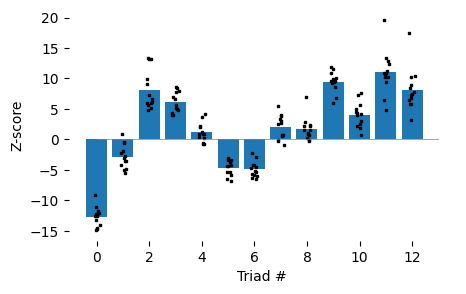

In [28]:
fig = plt.figure(figsize=(5, 3))
ax = fig.gca()

ax.bar(all_counts.columns, all_counts.mean())
x = numpy.repeat(all_counts.columns.values.reshape((1, -1)), len(all_counts), axis=0)
x = x + 0.25 * (numpy.random.rand(*x.shape) - 0.5)
ax.plot(x, all_counts.values, color="black", ls="None", marker='s', ms=2)
ax.plot([0, 13], [0, 0], color="grey", lw=0.5)
ax.set_frame_on(False)
ax.set_xlabel("Triad #")
ax.set_ylabel("Z-score")

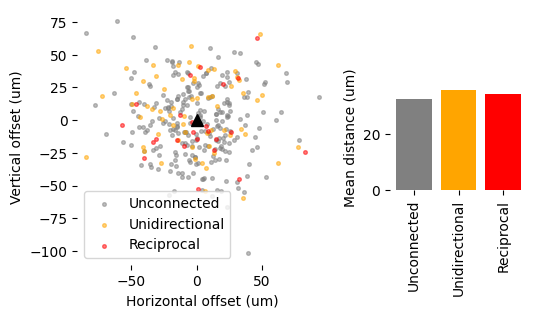

In [48]:
i = 0
d = all_deltas.loc[i]
d["distance"] = numpy.linalg.norm(d, axis=1)
dists = d.reset_index().groupby("level_0")["distance"].mean()

fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0.1, 0.1, 0.5, 0.85])

def sample_random_fraction(arr_in, frac):
    assert frac <= 1
    b = numpy.random.choice(len(arr_in), int(len(arr_in) * frac), replace=False)
    return arr_in.iloc[b]["horizontal"], arr_in.iloc[b]["vertical"]

ax.scatter(*sample_random_fraction(d.loc["unconnected"], 0.1), c="grey", s=7, alpha=0.5, label="Unconnected")
ax.scatter(*sample_random_fraction(d.loc["connected"], 0.1), c="orange", s=7, alpha=0.5, label="Unidirectional")
ax.scatter(*sample_random_fraction(d.loc["reciprocal"], 0.1), c="red", s=7, alpha=0.5, label="Reciprocal")
ax.plot(0, 0, marker="^", ms=8, color="black")
ax.set_xlabel("Horizontal offset (um)")
ax.set_ylabel("Vertical offset (um)")
ax.set_frame_on(False)
plt.axis("equal")
plt.legend()

ax = fig.add_axes([0.725, 0.35, 0.275, 0.35])
ax.bar(2, dists["reciprocal"], color="red")
ax.bar(1, dists["connected"], color="orange")
ax.bar(0, dists["unconnected"], color="grey")
ax.set_xticks([0, 1, 2]); ax.set_xticklabels(["Unconnected", "Unidirectional", "Reciprocal"], rotation="vertical")
ax.set_ylabel("Mean distance (um)")
ax.set_frame_on(False)

The purpose of the plot above is to show our sampling, and that it resembles in vitro sampling.

Also, we see that at this scale there is little to no distance-dependence: Unconnected, unidirectionally connected and reciprocally connected pairs are all at roughly the same distance.

## Part II: How the scale over which we sample affects things
This part includes a look at reciprocal connectivity: Is it over- or under-expressed?

In [53]:
szs = [40, 80, 120, 160, 200, 240, 280, 320, 360, 400]
all_counts = []
all_P = []
for sz_arg in [40, 80, 120, 160, 200, 240, 280, 320, 360, 400]:
    campaign_cfg = {
        "mv_cv": [[sz_arg**2, 0], [0, sz_arg**2]], # Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
        "patch_kwargs": {
            "slice_thickness": sz_arg * 2.5,
            "n_samples": 100, # The number of times the patch sampling procedure will be applied
            "n_patch": 12 # Up to this number of neurons will be sampled together
        }
    }

    counts, deltas, P = execute_slice_and_patch_campaign(M, campaign_cfg)
    all_counts.append(counts)
    all_P.append(P)
    
all_counts = pandas.concat(all_counts, axis=0, keys=szs, names=["scale"])
all_P = pandas.concat(all_P, axis=0, keys=szs, names=["scale"])  

  2%|▏         | 2/100 [00:00<00:16,  6.09it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012493133544921875
Found 106 connected triads
Time spent classifying triads: 0.010013818740844727
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013878345489501953
Found 202 connected triads
Time spent classifying triads: 0.009246826171875


  4%|▍         | 4/100 [00:00<00:15,  6.37it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014040470123291016
Found 164 connected triads
Time spent classifying triads: 0.00902557373046875
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014147758483886719
Found 207 connected triads
Time spent classifying triads: 0.008325338363647461


  6%|▌         | 6/100 [00:00<00:14,  6.61it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.001107931137084961
Found 65 connected triads
Time spent classifying triads: 0.006174802780151367
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012462139129638672
Found 154 connected triads
Time spent classifying triads: 0.006176471710205078


  8%|▊         | 8/100 [00:01<00:14,  6.37it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012900829315185547
Found 133 connected triads
Time spent classifying triads: 0.012535810470581055
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010952949523925781
Found 82 connected triads
Time spent classifying triads: 0.0033245086669921875


 10%|█         | 10/100 [00:01<00:14,  6.07it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001287221908569336
Found 147 connected triads
Time spent classifying triads: 0.007726192474365234
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011749267578125
Found 113 connected triads
Time spent classifying triads: 0.004622936248779297


 12%|█▏        | 12/100 [00:01<00:14,  6.13it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.00128173828125
Found 140 connected triads
Time spent classifying triads: 0.008735179901123047
Testing 62 potential triadic pairs
Time spent finding triads: 0.001190185546875
Found 119 connected triads
Time spent classifying triads: 0.004765748977661133


 14%|█▍        | 14/100 [00:02<00:13,  6.50it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012767314910888672
Found 141 connected triads
Time spent classifying triads: 0.006373405456542969
Testing 64 potential triadic pairs
Time spent finding triads: 0.00124359130859375
Found 151 connected triads
Time spent classifying triads: 0.00606226921081543


 16%|█▌        | 16/100 [00:02<00:13,  6.17it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013666152954101562
Found 171 connected triads
Time spent classifying triads: 0.01385951042175293
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012829303741455078
Found 163 connected triads
Time spent classifying triads: 0.006507396697998047


 18%|█▊        | 18/100 [00:02<00:12,  6.45it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012450218200683594
Found 122 connected triads
Time spent classifying triads: 0.011465311050415039
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011706352233886719
Found 121 connected triads
Time spent classifying triads: 0.0048487186431884766


 20%|██        | 20/100 [00:03<00:12,  6.62it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011146068572998047
Found 59 connected triads
Time spent classifying triads: 0.005635976791381836
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011832714080810547
Found 112 connected triads
Time spent classifying triads: 0.004499912261962891


 22%|██▏       | 22/100 [00:03<00:11,  6.75it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012133121490478516
Found 109 connected triads
Time spent classifying triads: 0.010298013687133789
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012066364288330078
Found 136 connected triads
Time spent classifying triads: 0.005415678024291992


 24%|██▍       | 24/100 [00:03<00:10,  6.91it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010502338409423828
Found 48 connected triads
Time spent classifying triads: 0.004611015319824219
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009615421295166016
Found 44 connected triads
Time spent classifying triads: 0.0018315315246582031


 26%|██▌       | 26/100 [00:04<00:11,  6.53it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012831687927246094
Found 132 connected triads
Time spent classifying triads: 0.007193088531494141
Testing 64 potential triadic pairs
Time spent finding triads: 0.001172780990600586
Found 108 connected triads
Time spent classifying triads: 0.004341602325439453


 28%|██▊       | 28/100 [00:04<00:11,  6.37it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013210773468017578
Found 160 connected triads
Time spent classifying triads: 0.007314920425415039
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013041496276855469
Found 174 connected triads
Time spent classifying triads: 0.006986856460571289


 30%|███       | 30/100 [00:04<00:10,  6.72it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013532638549804688
Found 172 connected triads
Time spent classifying triads: 0.007346391677856445
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 19 connected triads
Time spent classifying triads: 0.0008471012115478516


 32%|███▏      | 32/100 [00:04<00:10,  6.69it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013189315795898438
Found 171 connected triads
Time spent classifying triads: 0.0160982608795166
Testing 63 potential triadic pairs
Time spent finding triads: 0.001207590103149414
Found 124 connected triads
Time spent classifying triads: 0.004930257797241211


 34%|███▍      | 34/100 [00:05<00:10,  6.15it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013098716735839844
Found 158 connected triads
Time spent classifying triads: 0.014897584915161133
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012784004211425781
Found 166 connected triads
Time spent classifying triads: 0.006657123565673828


 36%|███▌      | 36/100 [00:05<00:09,  6.42it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012888908386230469
Found 147 connected triads
Time spent classifying triads: 0.01386713981628418
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009686946868896484
Found 55 connected triads
Time spent classifying triads: 0.002287149429321289


 38%|███▊      | 38/100 [00:05<00:09,  6.41it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013492107391357422
Found 169 connected triads
Time spent classifying triads: 0.007694244384765625
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012755393981933594
Found 172 connected triads
Time spent classifying triads: 0.006875276565551758


 40%|████      | 40/100 [00:06<00:09,  6.58it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013141632080078125
Found 160 connected triads
Time spent classifying triads: 0.007686138153076172
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012824535369873047
Found 173 connected triads
Time spent classifying triads: 0.006850004196166992


 42%|████▏     | 42/100 [00:06<00:08,  6.44it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011720657348632812
Found 85 connected triads
Time spent classifying triads: 0.008076667785644531
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009601116180419922
Found 43 connected triads
Time spent classifying triads: 0.0017845630645751953


 44%|████▍     | 44/100 [00:06<00:08,  6.61it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012331008911132812
Found 105 connected triads
Time spent classifying triads: 0.008666753768920898
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012936592102050781
Found 177 connected triads
Time spent classifying triads: 0.006993770599365234


 46%|████▌     | 46/100 [00:07<00:08,  6.56it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009119510650634766
Found 24 connected triads
Time spent classifying triads: 0.0023467540740966797
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012156963348388672
Found 125 connected triads
Time spent classifying triads: 0.004997968673706055


 48%|████▊     | 48/100 [00:07<00:08,  6.43it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013210773468017578
Found 170 connected triads
Time spent classifying triads: 0.015953540802001953
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011606216430664062
Found 118 connected triads
Time spent classifying triads: 0.004732847213745117


 50%|█████     | 50/100 [00:07<00:07,  6.30it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012874603271484375
Found 147 connected triads
Time spent classifying triads: 0.013823509216308594
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011169910430908203
Found 90 connected triads
Time spent classifying triads: 0.0036573410034179688


 52%|█████▏    | 52/100 [00:08<00:07,  6.52it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008780956268310547
Found 17 connected triads
Time spent classifying triads: 0.0017175674438476562
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012438297271728516
Found 160 connected triads
Time spent classifying triads: 0.006348609924316406


 54%|█████▍    | 54/100 [00:08<00:06,  6.62it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009543895721435547
Found 32 connected triads
Time spent classifying triads: 0.003107786178588867
Testing 63 potential triadic pairs
Time spent finding triads: 0.001138448715209961
Found 97 connected triads
Time spent classifying triads: 0.003897428512573242


 56%|█████▌    | 56/100 [00:08<00:06,  6.76it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010287761688232422
Found 43 connected triads
Time spent classifying triads: 0.004152059555053711
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009558200836181641
Found 42 connected triads
Time spent classifying triads: 0.001760244369506836


 58%|█████▊    | 58/100 [00:08<00:06,  6.51it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012900829315185547
Found 151 connected triads
Time spent classifying triads: 0.007497072219848633
Testing 62 potential triadic pairs
Time spent finding triads: 0.0012538433074951172
Found 151 connected triads
Time spent classifying triads: 0.006020784378051758


 60%|██████    | 60/100 [00:09<00:06,  6.60it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001275777816772461
Found 145 connected triads
Time spent classifying triads: 0.010889053344726562
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010945796966552734
Found 76 connected triads
Time spent classifying triads: 0.0030841827392578125


 62%|██████▏   | 62/100 [00:09<00:05,  6.69it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011031627655029297
Found 66 connected triads
Time spent classifying triads: 0.006293535232543945
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012059211730957031
Found 136 connected triads
Time spent classifying triads: 0.005445241928100586


 64%|██████▍   | 64/100 [00:09<00:05,  6.38it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001264333724975586
Found 136 connected triads
Time spent classifying triads: 0.012857913970947266
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011208057403564453
Found 90 connected triads
Time spent classifying triads: 0.0036449432373046875


 66%|██████▌   | 66/100 [00:10<00:05,  6.42it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011096000671386719
Found 63 connected triads
Time spent classifying triads: 0.0060062408447265625
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013117790222167969
Found 186 connected triads
Time spent classifying triads: 0.007445812225341797


 68%|██████▊   | 68/100 [00:10<00:04,  6.67it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013117790222167969
Found 151 connected triads
Time spent classifying triads: 0.014198780059814453
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008432865142822266
Found 23 connected triads
Time spent classifying triads: 0.0010173320770263672


 70%|███████   | 70/100 [00:10<00:04,  6.76it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012729167938232422
Found 131 connected triads
Time spent classifying triads: 0.012352466583251953
Testing 53 potential triadic pairs
Time spent finding triads: 0.001049041748046875
Found 70 connected triads
Time spent classifying triads: 0.0028374195098876953


 72%|███████▏  | 72/100 [00:11<00:04,  6.87it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.001024484634399414
Found 48 connected triads
Time spent classifying triads: 0.004586935043334961
Testing 60 potential triadic pairs
Time spent finding triads: 0.0010941028594970703
Found 80 connected triads
Time spent classifying triads: 0.0032410621643066406


 74%|███████▍  | 74/100 [00:11<00:03,  6.69it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.001102447509765625
Found 60 connected triads
Time spent classifying triads: 0.005711793899536133
Testing 63 potential triadic pairs
Time spent finding triads: 0.001211404800415039
Found 148 connected triads
Time spent classifying triads: 0.005867958068847656


 76%|███████▌  | 76/100 [00:11<00:03,  6.79it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0010755062103271484
Found 55 connected triads
Time spent classifying triads: 0.005353212356567383
Testing 57 potential triadic pairs
Time spent finding triads: 0.001085519790649414
Found 82 connected triads
Time spent classifying triads: 0.0033142566680908203


 78%|███████▊  | 78/100 [00:11<00:03,  6.84it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0009975433349609375
Found 50 connected triads
Time spent classifying triads: 0.0048024654388427734
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012965202331542969
Found 166 connected triads
Time spent classifying triads: 0.0066449642181396484


 80%|████████  | 80/100 [00:12<00:02,  6.83it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009636878967285156
Found 35 connected triads
Time spent classifying triads: 0.0033860206604003906
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010488033294677734
Found 62 connected triads
Time spent classifying triads: 0.0025467872619628906


 82%|████████▏ | 82/100 [00:12<00:02,  6.74it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013880729675292969
Found 182 connected triads
Time spent classifying triads: 0.008305788040161133
Testing 65 potential triadic pairs
Time spent finding triads: 0.001210927963256836
Found 144 connected triads
Time spent classifying triads: 0.0057642459869384766


 84%|████████▍ | 84/100 [00:12<00:02,  6.52it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011653900146484375
Found 87 connected triads
Time spent classifying triads: 0.004204750061035156
Testing 66 potential triadic pairs
Time spent finding triads: 0.001283407211303711
Found 170 connected triads
Time spent classifying triads: 0.006778717041015625


 86%|████████▌ | 86/100 [00:13<00:02,  6.40it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012173652648925781
Found 114 connected triads
Time spent classifying triads: 0.010785102844238281
Testing 65 potential triadic pairs
Time spent finding triads: 0.001275777816772461
Found 158 connected triads
Time spent classifying triads: 0.006312131881713867


 88%|████████▊ | 88/100 [00:13<00:01,  6.20it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012061595916748047
Found 94 connected triads
Time spent classifying triads: 0.008923768997192383
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009856224060058594
Found 46 connected triads
Time spent classifying triads: 0.0019268989562988281


 90%|█████████ | 90/100 [00:13<00:01,  6.36it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012500286102294922
Found 130 connected triads
Time spent classifying triads: 0.012250423431396484
Testing 66 potential triadic pairs
Time spent finding triads: 0.001291513442993164
Found 169 connected triads
Time spent classifying triads: 0.006869792938232422


 92%|█████████▏| 92/100 [00:14<00:01,  6.16it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012924671173095703
Found 135 connected triads
Time spent classifying triads: 0.008988142013549805
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012979507446289062
Found 180 connected triads
Time spent classifying triads: 0.0072290897369384766


 94%|█████████▍| 94/100 [00:14<00:00,  6.18it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0011980533599853516
Found 107 connected triads
Time spent classifying triads: 0.01010584831237793
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013527870178222656
Found 196 connected triads
Time spent classifying triads: 0.007806539535522461


 96%|█████████▌| 96/100 [00:14<00:00,  6.29it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011124610900878906
Found 77 connected triads
Time spent classifying triads: 0.007322072982788086
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009603500366210938
Found 41 connected triads
Time spent classifying triads: 0.001722574234008789


 98%|█████████▊| 98/100 [00:15<00:00,  6.40it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.001230478286743164
Found 118 connected triads
Time spent classifying triads: 0.01113581657409668
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012409687042236328
Found 149 connected triads
Time spent classifying triads: 0.00594782829284668


100%|██████████| 100/100 [00:15<00:00,  6.49it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0012998580932617188
Found 148 connected triads
Time spent classifying triads: 0.013935565948486328
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011143684387207031
Found 82 connected triads
Time spent classifying triads: 0.0033316612243652344


  2%|▏         | 2/100 [00:00<00:19,  4.99it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009744167327880859
Found 28 connected triads
Time spent classifying triads: 0.0027344226837158203
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011570453643798828
Found 100 connected triads
Time spent classifying triads: 0.003987312316894531


  4%|▍         | 4/100 [00:00<00:19,  5.03it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.001049041748046875
Found 54 connected triads
Time spent classifying triads: 0.005139589309692383
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012366771697998047
Found 143 connected triads
Time spent classifying triads: 0.00565648078918457


  5%|▌         | 5/100 [00:00<00:18,  5.07it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009505748748779297
Found 25 connected triads
Time spent classifying triads: 0.0023927688598632812


  7%|▋         | 7/100 [00:01<00:18,  4.90it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010366439819335938
Found 45 connected triads
Time spent classifying triads: 0.0043489933013916016
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011913776397705078
Found 115 connected triads
Time spent classifying triads: 0.0045735836029052734


  9%|▉         | 9/100 [00:01<00:18,  4.89it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012896060943603516
Found 139 connected triads
Time spent classifying triads: 0.013029336929321289
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009953975677490234
Found 51 connected triads
Time spent classifying triads: 0.002122163772583008


 10%|█         | 10/100 [00:02<00:19,  4.59it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012722015380859375
Found 128 connected triads
Time spent classifying triads: 0.012550592422485352


 11%|█         | 11/100 [00:02<00:19,  4.64it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0016596317291259766
Found 20 connected triads
Time spent classifying triads: 0.0018939971923828125


 13%|█▎        | 13/100 [00:02<00:18,  4.71it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013251304626464844
Found 175 connected triads
Time spent classifying triads: 0.016486406326293945
Testing 37 potential triadic pairs
Time spent finding triads: 0.000949859619140625
Found 44 connected triads
Time spent classifying triads: 0.0018563270568847656


 15%|█▌        | 15/100 [00:03<00:17,  5.00it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009267330169677734
Found 22 connected triads
Time spent classifying triads: 0.002183675765991211
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010869503021240234
Found 74 connected triads
Time spent classifying triads: 0.0031065940856933594


 17%|█▋        | 17/100 [00:03<00:16,  5.18it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009219646453857422
Found 17 connected triads
Time spent classifying triads: 0.0017211437225341797
Testing 45 potential triadic pairs
Time spent finding triads: 0.0009970664978027344
Found 43 connected triads
Time spent classifying triads: 0.0017902851104736328


 19%|█▉        | 19/100 [00:03<00:15,  5.24it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012240409851074219
Found 104 connected triads
Time spent classifying triads: 0.009825706481933594
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011339187622070312
Found 100 connected triads
Time spent classifying triads: 0.0039997100830078125


 21%|██        | 21/100 [00:04<00:15,  5.19it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0012409687042236328
Found 66 connected triads
Time spent classifying triads: 0.006285429000854492
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009114742279052734
Found 33 connected triads
Time spent classifying triads: 0.0014209747314453125


 23%|██▎       | 23/100 [00:04<00:15,  5.13it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011975765228271484
Found 84 connected triads
Time spent classifying triads: 0.00796651840209961
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010144710540771484
Found 51 connected triads
Time spent classifying triads: 0.0021016597747802734


 25%|██▌       | 25/100 [00:05<00:14,  5.16it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010747909545898438
Found 57 connected triads
Time spent classifying triads: 0.0034439563751220703
Testing 66 potential triadic pairs
Time spent finding triads: 0.00122833251953125
Found 139 connected triads
Time spent classifying triads: 0.005589008331298828


 26%|██▌       | 26/100 [00:05<00:14,  5.18it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009450912475585938
Found 22 connected triads
Time spent classifying triads: 0.0021936893463134766
Testing 52 potential triadic pairs
Time spent finding triads: 0.001093149185180664
Found 64 connected triads
Time spent classifying triads: 0.002619028091430664


 29%|██▉       | 29/100 [00:05<00:13,  5.17it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 1 connected triads
Time spent classifying triads: 0.0001990795135498047
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008699893951416016
Found 24 connected triads
Time spent classifying triads: 0.0010650157928466797


 30%|███       | 30/100 [00:06<00:13,  5.18it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011317729949951172
Found 74 connected triads
Time spent classifying triads: 0.006992340087890625


 32%|███▏      | 32/100 [00:06<00:13,  5.07it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012331008911132812
Found 113 connected triads
Time spent classifying triads: 0.0052683353424072266
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007693767547607422
Found 6 connected triads
Time spent classifying triads: 0.0003428459167480469


 34%|███▍      | 34/100 [00:06<00:12,  5.13it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012192726135253906
Found 99 connected triads
Time spent classifying triads: 0.005224466323852539
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008349418640136719
Found 16 connected triads
Time spent classifying triads: 0.0007381439208984375


 35%|███▌      | 35/100 [00:06<00:12,  5.21it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008716583251953125
Found 19 connected triads
Time spent classifying triads: 0.001678466796875


 37%|███▋      | 37/100 [00:07<00:12,  5.04it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012443065643310547
Found 122 connected triads
Time spent classifying triads: 0.011487960815429688
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011539459228515625
Found 96 connected triads
Time spent classifying triads: 0.003859996795654297


 39%|███▉      | 39/100 [00:07<00:12,  4.95it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012166500091552734
Found 103 connected triads
Time spent classifying triads: 0.009735107421875
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012068748474121094
Found 126 connected triads
Time spent classifying triads: 0.0050203800201416016


 41%|████      | 41/100 [00:08<00:11,  5.03it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012238025665283203
Found 99 connected triads
Time spent classifying triads: 0.009353876113891602
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010387897491455078
Found 56 connected triads
Time spent classifying triads: 0.002303600311279297


 43%|████▎     | 43/100 [00:08<00:11,  5.18it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010128021240234375
Found 39 connected triads
Time spent classifying triads: 0.0037686824798583984
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009591579437255859
Found 37 connected triads
Time spent classifying triads: 0.0015642642974853516


 44%|████▍     | 44/100 [00:08<00:11,  5.04it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009093284606933594
Found 20 connected triads
Time spent classifying triads: 0.0019860267639160156
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009291172027587891
Found 35 connected triads
Time spent classifying triads: 0.0014889240264892578


 46%|████▌     | 46/100 [00:09<00:10,  5.08it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0012011528015136719
Found 98 connected triads
Time spent classifying triads: 0.009247303009033203


 48%|████▊     | 48/100 [00:09<00:10,  5.00it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010750293731689453
Found 59 connected triads
Time spent classifying triads: 0.005655527114868164
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009140968322753906
Found 30 connected triads
Time spent classifying triads: 0.0012919902801513672


 50%|█████     | 50/100 [00:09<00:09,  5.24it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 5 connected triads
Time spent classifying triads: 0.0005910396575927734
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012788772583007812
Found 153 connected triads
Time spent classifying triads: 0.0061016082763671875


 52%|█████▏    | 52/100 [00:10<00:09,  5.14it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008025169372558594
Found 2 connected triads
Time spent classifying triads: 0.00028204917907714844
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007474422454833984
Found 5 connected triads
Time spent classifying triads: 0.00031495094299316406


 54%|█████▍    | 54/100 [00:10<00:08,  5.14it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013227462768554688
Found 153 connected triads
Time spent classifying triads: 0.006518840789794922
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011963844299316406
Found 109 connected triads
Time spent classifying triads: 0.004522800445556641


 56%|█████▌    | 56/100 [00:11<00:08,  5.28it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011134147644042969
Found 61 connected triads
Time spent classifying triads: 0.005818843841552734
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011775493621826172
Found 101 connected triads
Time spent classifying triads: 0.00406336784362793


 58%|█████▊    | 58/100 [00:11<00:07,  5.30it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011744499206542969
Found 83 connected triads
Time spent classifying triads: 0.007896184921264648
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010838508605957031
Found 82 connected triads
Time spent classifying triads: 0.0033195018768310547


 60%|██████    | 60/100 [00:11<00:07,  5.32it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010650157928466797
Found 46 connected triads
Time spent classifying triads: 0.004448413848876953
Testing 54 potential triadic pairs
Time spent finding triads: 0.001077413558959961
Found 67 connected triads
Time spent classifying triads: 0.002740621566772461


 62%|██████▏   | 62/100 [00:12<00:07,  5.29it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010547637939453125
Found 42 connected triads
Time spent classifying triads: 0.004050016403198242
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008158683776855469
Found 13 connected triads
Time spent classifying triads: 0.0006148815155029297


 63%|██████▎   | 63/100 [00:12<00:07,  5.10it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013115406036376953
Found 135 connected triads
Time spent classifying triads: 0.012732267379760742
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012998580932617188
Found 93 connected triads
Time spent classifying triads: 0.008797883987426758


 65%|██████▌   | 65/100 [00:12<00:07,  4.76it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.001043558120727539
Found 39 connected triads
Time spent classifying triads: 0.0021975040435791016


 66%|██████▌   | 66/100 [00:13<00:07,  4.73it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0017867088317871094
Found 98 connected triads
Time spent classifying triads: 0.009367704391479492


 67%|██████▋   | 67/100 [00:13<00:07,  4.69it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.002298593521118164
Found 107 connected triads
Time spent classifying triads: 0.009881973266601562


 69%|██████▉   | 69/100 [00:13<00:06,  4.89it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0018236637115478516
Found 101 connected triads
Time spent classifying triads: 0.00958251953125
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009393692016601562
Found 32 connected triads
Time spent classifying triads: 0.0013663768768310547


 71%|███████   | 71/100 [00:14<00:05,  5.10it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 3 connected triads
Time spent classifying triads: 0.00041961669921875
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008563995361328125
Found 21 connected triads
Time spent classifying triads: 0.0009398460388183594


 73%|███████▎  | 73/100 [00:14<00:05,  5.12it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013072490692138672
Found 139 connected triads
Time spent classifying triads: 0.01202392578125
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010004043579101562
Found 49 connected triads
Time spent classifying triads: 0.002021312713623047


 75%|███████▌  | 75/100 [00:14<00:04,  5.20it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009665489196777344
Found 31 connected triads
Time spent classifying triads: 0.003007650375366211
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011763572692871094
Found 120 connected triads
Time spent classifying triads: 0.004799604415893555


 77%|███████▋  | 77/100 [00:15<00:04,  5.01it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008575916290283203
Found 14 connected triads
Time spent classifying triads: 0.0014278888702392578
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011091232299804688
Found 87 connected triads
Time spent classifying triads: 0.0035092830657958984


 78%|███████▊  | 78/100 [00:15<00:04,  5.14it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.000993967056274414
Found 30 connected triads
Time spent classifying triads: 0.002916097640991211


 80%|████████  | 80/100 [00:15<00:03,  5.09it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008516311645507812
Found 11 connected triads
Time spent classifying triads: 0.0012192726135253906
Testing 64 potential triadic pairs
Time spent finding triads: 0.0013103485107421875
Found 149 connected triads
Time spent classifying triads: 0.006001949310302734


 82%|████████▏ | 82/100 [00:16<00:03,  5.01it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.00128936767578125
Found 125 connected triads
Time spent classifying triads: 0.005420684814453125
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011513233184814453
Found 104 connected triads
Time spent classifying triads: 0.004282951354980469


 83%|████████▎ | 83/100 [00:16<00:03,  4.84it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011806488037109375
Found 86 connected triads
Time spent classifying triads: 0.00819540023803711


 85%|████████▌ | 85/100 [00:16<00:03,  4.81it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.001058340072631836
Found 61 connected triads
Time spent classifying triads: 0.005823850631713867
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 13 connected triads
Time spent classifying triads: 0.0006203651428222656


 87%|████████▋ | 87/100 [00:17<00:02,  4.91it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.001207590103149414
Found 100 connected triads
Time spent classifying triads: 0.009435892105102539
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008602142333984375
Found 21 connected triads
Time spent classifying triads: 0.0009284019470214844


 89%|████████▉ | 89/100 [00:17<00:02,  4.89it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012311935424804688
Found 111 connected triads
Time spent classifying triads: 0.010462045669555664
Testing 42 potential triadic pairs
Time spent finding triads: 0.0010232925415039062
Found 68 connected triads
Time spent classifying triads: 0.0030128955841064453


 91%|█████████ | 91/100 [00:18<00:01,  4.91it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0010478496551513672
Found 29 connected triads
Time spent classifying triads: 0.0014476776123046875
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013759136199951172
Found 202 connected triads
Time spent classifying triads: 0.007982254028320312


 93%|█████████▎| 93/100 [00:18<00:01,  5.00it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011599063873291016
Found 94 connected triads
Time spent classifying triads: 0.008920907974243164
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009424686431884766
Found 33 connected triads
Time spent classifying triads: 0.0014107227325439453


 95%|█████████▌| 95/100 [00:18<00:00,  5.17it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010819435119628906
Found 64 connected triads
Time spent classifying triads: 0.006134986877441406
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011065006256103516
Found 96 connected triads
Time spent classifying triads: 0.003879547119140625


 97%|█████████▋| 97/100 [00:19<00:00,  5.06it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010693073272705078
Found 62 connected triads
Time spent classifying triads: 0.00543212890625
Testing 65 potential triadic pairs
Time spent finding triads: 0.001226186752319336
Found 131 connected triads
Time spent classifying triads: 0.005238533020019531


 99%|█████████▉| 99/100 [00:19<00:00,  5.24it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010929107666015625
Found 56 connected triads
Time spent classifying triads: 0.005360841751098633
Testing 60 potential triadic pairs
Time spent finding triads: 0.001157999038696289
Found 98 connected triads
Time spent classifying triads: 0.003945589065551758


100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


Testing 51 potential triadic pairs
Time spent finding triads: 0.0011179447174072266
Found 68 connected triads
Time spent classifying triads: 0.006803274154663086


  1%|          | 1/100 [00:00<00:20,  4.77it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009510517120361328
Found 22 connected triads
Time spent classifying triads: 0.0021669864654541016


  2%|▏         | 2/100 [00:00<00:20,  4.79it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0014255046844482422
Found 12 connected triads
Time spent classifying triads: 0.0010366439819335938


  3%|▎         | 3/100 [00:00<00:23,  4.21it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008771419525146484
Found 16 connected triads
Time spent classifying triads: 0.0016283988952636719


  4%|▍         | 4/100 [00:00<00:22,  4.28it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009005069732666016
Found 12 connected triads
Time spent classifying triads: 0.0012595653533935547


  5%|▌         | 5/100 [00:01<00:22,  4.31it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.000934600830078125
Found 25 connected triads
Time spent classifying triads: 0.0016033649444580078


  6%|▌         | 6/100 [00:01<00:21,  4.46it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0016803741455078125
Found 52 connected triads
Time spent classifying triads: 0.0049877166748046875


  7%|▋         | 7/100 [00:01<00:21,  4.43it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011153221130371094
Found 65 connected triads
Time spent classifying triads: 0.006214141845703125


  8%|▊         | 8/100 [00:01<00:20,  4.47it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009074211120605469
Found 19 connected triads
Time spent classifying triads: 0.0019156932830810547


  9%|▉         | 9/100 [00:02<00:21,  4.18it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010263919830322266
Found 41 connected triads
Time spent classifying triads: 0.003966808319091797


 10%|█         | 10/100 [00:02<00:22,  4.01it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009829998016357422
Found 32 connected triads
Time spent classifying triads: 0.0031125545501708984


 11%|█         | 11/100 [00:02<00:21,  4.08it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008349418640136719
Found 8 connected triads
Time spent classifying triads: 0.0008652210235595703


 12%|█▏        | 12/100 [00:02<00:20,  4.22it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.000896453857421875
Found 18 connected triads
Time spent classifying triads: 0.0018146038055419922


 13%|█▎        | 13/100 [00:03<00:20,  4.23it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010523796081542969
Found 41 connected triads
Time spent classifying triads: 0.003970146179199219


 14%|█▍        | 14/100 [00:03<00:19,  4.32it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0010044574737548828
Found 45 connected triads
Time spent classifying triads: 0.004324674606323242


 15%|█▌        | 15/100 [00:03<00:19,  4.27it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010941028594970703
Found 54 connected triads
Time spent classifying triads: 0.00394892692565918


 16%|█▌        | 16/100 [00:03<00:19,  4.28it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0010008811950683594
Found 45 connected triads
Time spent classifying triads: 0.00433659553527832


 17%|█▋        | 17/100 [00:03<00:18,  4.38it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008268356323242188
Found 6 connected triads
Time spent classifying triads: 0.000698089599609375


 18%|█▊        | 18/100 [00:04<00:18,  4.47it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008478164672851562
Found 10 connected triads
Time spent classifying triads: 0.0010650157928466797


 19%|█▉        | 19/100 [00:04<00:19,  4.20it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010924339294433594
Found 56 connected triads
Time spent classifying triads: 0.005377531051635742


 20%|██        | 20/100 [00:04<00:18,  4.29it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009868144989013672
Found 35 connected triads
Time spent classifying triads: 0.003408193588256836


 21%|██        | 21/100 [00:04<00:18,  4.37it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0010900497436523438
Found 58 connected triads
Time spent classifying triads: 0.0055561065673828125


 22%|██▏       | 22/100 [00:05<00:17,  4.43it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011012554168701172
Found 64 connected triads
Time spent classifying triads: 0.006114006042480469


 23%|██▎       | 23/100 [00:05<00:18,  4.20it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009808540344238281
Found 35 connected triads
Time spent classifying triads: 0.0033919811248779297


 24%|██▍       | 24/100 [00:05<00:17,  4.33it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0018002986907958984
Found 61 connected triads
Time spent classifying triads: 0.0038208961486816406


 25%|██▌       | 25/100 [00:05<00:16,  4.43it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0012552738189697266
Found 44 connected triads
Time spent classifying triads: 0.0042226314544677734


 26%|██▌       | 26/100 [00:05<00:16,  4.50it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0010256767272949219
Found 16 connected triads
Time spent classifying triads: 0.0012352466583251953


 27%|██▋       | 27/100 [00:06<00:16,  4.45it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.001046895980834961
Found 24 connected triads
Time spent classifying triads: 0.0018999576568603516


 28%|██▊       | 28/100 [00:06<00:16,  4.45it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011188983917236328
Found 68 connected triads
Time spent classifying triads: 0.006262540817260742


 29%|██▉       | 29/100 [00:06<00:16,  4.43it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.001149892807006836
Found 71 connected triads
Time spent classifying triads: 0.00680851936340332


 30%|███       | 30/100 [00:06<00:15,  4.53it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0012362003326416016
Found 13 connected triads
Time spent classifying triads: 0.0006353855133056641


 31%|███       | 31/100 [00:07<00:16,  4.25it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 6 connected triads
Time spent classifying triads: 0.0006873607635498047


 32%|███▏      | 32/100 [00:07<00:15,  4.32it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011856555938720703
Found 93 connected triads
Time spent classifying triads: 0.008800268173217773


 33%|███▎      | 33/100 [00:07<00:15,  4.39it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0013103485107421875
Found 60 connected triads
Time spent classifying triads: 0.005699634552001953


 34%|███▍      | 34/100 [00:07<00:14,  4.46it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010037422180175781
Found 41 connected triads
Time spent classifying triads: 0.00394129753112793


 35%|███▌      | 35/100 [00:08<00:14,  4.52it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009856224060058594
Found 35 connected triads
Time spent classifying triads: 0.003394603729248047


 36%|███▌      | 36/100 [00:08<00:15,  4.24it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009455680847167969
Found 31 connected triads
Time spent classifying triads: 0.0030145645141601562


 37%|███▋      | 37/100 [00:08<00:14,  4.26it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0009813308715820312
Found 29 connected triads
Time spent classifying triads: 0.0028345584869384766


 38%|███▊      | 38/100 [00:08<00:15,  4.08it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008664131164550781
Found 5 connected triads
Time spent classifying triads: 0.0005884170532226562


 39%|███▉      | 39/100 [00:09<00:15,  3.93it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0011031627655029297
Found 39 connected triads
Time spent classifying triads: 0.003304719924926758


 40%|████      | 40/100 [00:09<00:15,  3.90it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007641315460205078
Found 0 connected triads
Time spent classifying triads: 7.581710815429688e-05
Testing 11 potential triadic pairs
Time spent finding triads: 0.000926971435546875
Found 15 connected triads
Time spent classifying triads: 0.0015299320220947266


 42%|████▏     | 42/100 [00:09<00:13,  4.24it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009238719940185547
Found 21 connected triads
Time spent classifying triads: 0.002092599868774414


 43%|████▎     | 43/100 [00:09<00:13,  4.33it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009598731994628906
Found 31 connected triads
Time spent classifying triads: 0.0030236244201660156


 44%|████▍     | 44/100 [00:10<00:12,  4.36it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010943412780761719
Found 54 connected triads
Time spent classifying triads: 0.0052204132080078125
Testing 40 potential triadic pairs
Time spent finding triads: 0.0012960433959960938
Found 40 connected triads
Time spent classifying triads: 0.0038640499114990234


 46%|████▌     | 46/100 [00:10<00:11,  4.53it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0012500286102294922
Found 57 connected triads
Time spent classifying triads: 0.005432605743408203


 47%|████▋     | 47/100 [00:10<00:11,  4.43it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010561943054199219
Found 52 connected triads
Time spent classifying triads: 0.00500035285949707


 48%|████▊     | 48/100 [00:11<00:12,  4.17it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009500980377197266
Found 28 connected triads
Time spent classifying triads: 0.0027549266815185547


 49%|████▉     | 49/100 [00:11<00:11,  4.32it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0012476444244384766
Found 20 connected triads
Time spent classifying triads: 0.0016565322875976562


 50%|█████     | 50/100 [00:11<00:11,  4.42it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008356571197509766
Found 9 connected triads
Time spent classifying triads: 0.0009634494781494141


 51%|█████     | 51/100 [00:11<00:11,  4.42it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0011072158813476562
Found 57 connected triads
Time spent classifying triads: 0.005472421646118164


 52%|█████▏    | 52/100 [00:12<00:10,  4.52it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0016257762908935547
Found 34 connected triads
Time spent classifying triads: 0.002772092819213867


 53%|█████▎    | 53/100 [00:12<00:10,  4.52it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009937286376953125
Found 37 connected triads
Time spent classifying triads: 0.00202178955078125


 54%|█████▍    | 54/100 [00:12<00:10,  4.50it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009827613830566406
Found 33 connected triads
Time spent classifying triads: 0.0032341480255126953


 55%|█████▌    | 55/100 [00:12<00:09,  4.52it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.000993967056274414
Found 37 connected triads
Time spent classifying triads: 0.0035712718963623047


 56%|█████▌    | 56/100 [00:12<00:09,  4.58it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.002165079116821289
Found 88 connected triads
Time spent classifying triads: 0.004182338714599609


 57%|█████▋    | 57/100 [00:13<00:09,  4.47it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009257793426513672
Found 27 connected triads
Time spent classifying triads: 0.002663135528564453


 58%|█████▊    | 58/100 [00:13<00:09,  4.48it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011012554168701172
Found 57 connected triads
Time spent classifying triads: 0.005448818206787109


 59%|█████▉    | 59/100 [00:13<00:09,  4.47it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010769367218017578
Found 55 connected triads
Time spent classifying triads: 0.005240440368652344


 60%|██████    | 60/100 [00:13<00:09,  4.44it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009801387786865234
Found 36 connected triads
Time spent classifying triads: 0.003498077392578125


 61%|██████    | 61/100 [00:14<00:08,  4.48it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008628368377685547
Found 14 connected triads
Time spent classifying triads: 0.0015561580657958984


 62%|██████▏   | 62/100 [00:14<00:08,  4.50it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009937286376953125
Found 44 connected triads
Time spent classifying triads: 0.004237651824951172


 63%|██████▎   | 63/100 [00:14<00:08,  4.51it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0012135505676269531
Found 116 connected triads
Time spent classifying triads: 0.00669550895690918


 64%|██████▍   | 64/100 [00:14<00:07,  4.56it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 3 connected triads
Time spent classifying triads: 0.00040149688720703125


 65%|██████▌   | 65/100 [00:14<00:08,  4.23it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009784698486328125
Found 35 connected triads
Time spent classifying triads: 0.0033838748931884766


 66%|██████▌   | 66/100 [00:15<00:08,  4.06it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.001180410385131836
Found 96 connected triads
Time spent classifying triads: 0.00445556640625


 67%|██████▋   | 67/100 [00:15<00:07,  4.14it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010180473327636719
Found 41 connected triads
Time spent classifying triads: 0.003962278366088867


 68%|██████▊   | 68/100 [00:15<00:07,  4.15it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.001088857650756836
Found 53 connected triads
Time spent classifying triads: 0.005130290985107422


 69%|██████▉   | 69/100 [00:15<00:07,  4.00it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.000904083251953125
Found 23 connected triads
Time spent classifying triads: 0.0022735595703125


 70%|███████   | 70/100 [00:16<00:07,  4.18it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0018246173858642578
Found 78 connected triads
Time spent classifying triads: 0.007477998733520508


 71%|███████   | 71/100 [00:16<00:06,  4.32it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009200572967529297
Found 20 connected triads
Time spent classifying triads: 0.001993417739868164


 72%|███████▏  | 72/100 [00:16<00:06,  4.36it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010256767272949219
Found 47 connected triads
Time spent classifying triads: 0.004538536071777344


 73%|███████▎  | 73/100 [00:16<00:06,  4.42it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 5 connected triads
Time spent classifying triads: 0.0005917549133300781


 74%|███████▍  | 74/100 [00:17<00:05,  4.51it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0012650489807128906
Found 14 connected triads
Time spent classifying triads: 0.0011854171752929688


 75%|███████▌  | 75/100 [00:17<00:05,  4.22it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008873939514160156
Found 17 connected triads
Time spent classifying triads: 0.0017156600952148438


 76%|███████▌  | 76/100 [00:17<00:05,  4.05it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.001199483871459961
Found 102 connected triads
Time spent classifying triads: 0.00966191291809082


 77%|███████▋  | 77/100 [00:17<00:05,  4.18it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009329319000244141
Found 27 connected triads
Time spent classifying triads: 0.0026357173919677734


 78%|███████▊  | 78/100 [00:18<00:05,  4.33it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0013172626495361328
Found 27 connected triads
Time spent classifying triads: 0.0021860599517822266


 79%|███████▉  | 79/100 [00:18<00:04,  4.41it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008387565612792969
Found 11 connected triads
Time spent classifying triads: 0.0011479854583740234


 80%|████████  | 80/100 [00:18<00:04,  4.42it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.001142263412475586
Found 74 connected triads
Time spent classifying triads: 0.007047176361083984


 81%|████████  | 81/100 [00:18<00:04,  4.19it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010614395141601562
Found 58 connected triads
Time spent classifying triads: 0.005532026290893555


 82%|████████▏ | 82/100 [00:18<00:04,  4.28it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009942054748535156
Found 35 connected triads
Time spent classifying triads: 0.0034067630767822266


 83%|████████▎ | 83/100 [00:19<00:03,  4.37it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009267330169677734
Found 28 connected triads
Time spent classifying triads: 0.0027430057525634766


 84%|████████▍ | 84/100 [00:19<00:03,  4.42it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012149810791015625
Found 87 connected triads
Time spent classifying triads: 0.006166696548461914


 85%|████████▌ | 85/100 [00:19<00:03,  4.46it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011487007141113281
Found 88 connected triads
Time spent classifying triads: 0.006829261779785156


 86%|████████▌ | 86/100 [00:19<00:03,  4.21it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008234977722167969
Found 7 connected triads
Time spent classifying triads: 0.0007812976837158203


 87%|████████▋ | 87/100 [00:20<00:03,  4.32it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.001041412353515625
Found 50 connected triads
Time spent classifying triads: 0.00477910041809082
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009441375732421875
Found 43 connected triads


 88%|████████▊ | 88/100 [00:20<00:02,  4.46it/s]

Time spent classifying triads: 0.0037560462951660156


 89%|████████▉ | 89/100 [00:20<00:02,  4.45it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009546279907226562
Found 30 connected triads
Time spent classifying triads: 0.002611398696899414


 90%|█████████ | 90/100 [00:20<00:02,  4.47it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007822513580322266
Found 2 connected triads
Time spent classifying triads: 0.00029206275939941406


 91%|█████████ | 91/100 [00:20<00:01,  4.54it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.001664876937866211
Found 86 connected triads
Time spent classifying triads: 0.008138656616210938


 92%|█████████▏| 92/100 [00:21<00:01,  4.52it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.00115966796875
Found 91 connected triads
Time spent classifying triads: 0.005364894866943359


 93%|█████████▎| 93/100 [00:21<00:01,  4.54it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011036396026611328
Found 61 connected triads
Time spent classifying triads: 0.005809307098388672


 94%|█████████▍| 94/100 [00:21<00:01,  4.53it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.001003265380859375
Found 37 connected triads
Time spent classifying triads: 0.003574371337890625


 95%|█████████▌| 95/100 [00:21<00:01,  4.56it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009503364562988281
Found 24 connected triads
Time spent classifying triads: 0.0023658275604248047


 96%|█████████▌| 96/100 [00:22<00:00,  4.53it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011708736419677734
Found 96 connected triads
Time spent classifying triads: 0.009087800979614258


 97%|█████████▋| 97/100 [00:22<00:00,  4.58it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0015740394592285156
Found 76 connected triads
Time spent classifying triads: 0.007405757904052734
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008084774017333984
Found 13 connected triads
Time spent classifying triads: 0.0006175041198730469


 99%|█████████▉| 99/100 [00:22<00:00,  4.34it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0011594295501708984
Found 82 connected triads
Time spent classifying triads: 0.004606962203979492


100%|██████████| 100/100 [00:22<00:00,  4.35it/s]


Testing 45 potential triadic pairs
Time spent finding triads: 0.0010437965393066406
Found 49 connected triads
Time spent classifying triads: 0.0047147274017333984


  1%|          | 1/100 [00:00<00:24,  4.11it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008244514465332031
Found 4 connected triads
Time spent classifying triads: 0.0004913806915283203


  2%|▏         | 2/100 [00:00<00:24,  4.02it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008778572082519531
Found 9 connected triads
Time spent classifying triads: 0.0009777545928955078


  3%|▎         | 3/100 [00:00<00:25,  3.86it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.000843048095703125
Found 6 connected triads
Time spent classifying triads: 0.0006871223449707031


  4%|▍         | 4/100 [00:01<00:26,  3.63it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009779930114746094
Found 26 connected triads
Time spent classifying triads: 0.0025606155395507812


  5%|▌         | 5/100 [00:01<00:25,  3.74it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011343955993652344
Found 67 connected triads
Time spent classifying triads: 0.0063664913177490234


  6%|▌         | 6/100 [00:01<00:24,  3.85it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008845329284667969
Found 12 connected triads
Time spent classifying triads: 0.0012683868408203125


  7%|▋         | 7/100 [00:01<00:25,  3.65it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.000911712646484375
Found 13 connected triads
Time spent classifying triads: 0.0013546943664550781


  8%|▊         | 8/100 [00:02<00:25,  3.64it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008835792541503906
Found 13 connected triads
Time spent classifying triads: 0.0013599395751953125


  9%|▉         | 9/100 [00:02<00:24,  3.69it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010650157928466797
Found 46 connected triads
Time spent classifying triads: 0.004452228546142578


 10%|█         | 10/100 [00:02<00:24,  3.65it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009548664093017578
Found 20 connected triads
Time spent classifying triads: 0.0020127296447753906


 11%|█         | 11/100 [00:02<00:24,  3.60it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


 12%|█▏        | 12/100 [00:03<00:24,  3.61it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 6 connected triads
Time spent classifying triads: 0.0006957054138183594


 13%|█▎        | 13/100 [00:03<00:23,  3.71it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009009838104248047
Found 16 connected triads
Time spent classifying triads: 0.0016202926635742188


 14%|█▍        | 14/100 [00:03<00:22,  3.84it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 5 connected triads
Time spent classifying triads: 0.0006077289581298828


 15%|█▌        | 15/100 [00:04<00:22,  3.85it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.000926971435546875
Found 16 connected triads
Time spent classifying triads: 0.0016298294067382812


 16%|█▌        | 16/100 [00:04<00:22,  3.71it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010373592376708984
Found 38 connected triads
Time spent classifying triads: 0.0036895275115966797


 17%|█▋        | 17/100 [00:04<00:22,  3.76it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010488033294677734
Found 46 connected triads
Time spent classifying triads: 0.004426240921020508


 18%|█▊        | 18/100 [00:04<00:22,  3.62it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009808540344238281
Found 33 connected triads
Time spent classifying triads: 0.0032405853271484375


 19%|█▉        | 19/100 [00:05<00:22,  3.53it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008511543273925781
Found 8 connected triads
Time spent classifying triads: 0.0008938312530517578


 20%|██        | 20/100 [00:05<00:21,  3.65it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008013248443603516
Found 1 connected triads
Time spent classifying triads: 0.00020241737365722656


 21%|██        | 21/100 [00:05<00:21,  3.69it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008523464202880859
Found 8 connected triads
Time spent classifying triads: 0.0009565353393554688


 22%|██▏       | 22/100 [00:05<00:20,  3.78it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 4 connected triads
Time spent classifying triads: 0.0005047321319580078


 23%|██▎       | 23/100 [00:06<00:19,  3.86it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 5 connected triads
Time spent classifying triads: 0.0006046295166015625


 24%|██▍       | 24/100 [00:06<00:20,  3.75it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009551048278808594
Found 27 connected triads
Time spent classifying triads: 0.0026557445526123047


 25%|██▌       | 25/100 [00:06<00:19,  3.80it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0011000633239746094
Found 51 connected triads
Time spent classifying triads: 0.0039942264556884766


 26%|██▌       | 26/100 [00:06<00:19,  3.76it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008649826049804688
Found 10 connected triads
Time spent classifying triads: 0.001065969467163086


 27%|██▋       | 27/100 [00:07<00:19,  3.76it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009260177612304688
Found 16 connected triads
Time spent classifying triads: 0.0016334056854248047


 28%|██▊       | 28/100 [00:07<00:19,  3.67it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.001077890396118164
Found 55 connected triads
Time spent classifying triads: 0.005267143249511719


 29%|██▉       | 29/100 [00:07<00:18,  3.74it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008459091186523438
Found 8 connected triads
Time spent classifying triads: 0.0008873939514160156


 30%|███       | 30/100 [00:08<00:19,  3.59it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009658336639404297
Found 24 connected triads
Time spent classifying triads: 0.002376079559326172


 31%|███       | 31/100 [00:08<00:18,  3.71it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009064674377441406
Found 18 connected triads
Time spent classifying triads: 0.0018072128295898438


 32%|███▏      | 32/100 [00:08<00:17,  3.79it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008747577667236328
Found 13 connected triads
Time spent classifying triads: 0.0013413429260253906


 33%|███▎      | 33/100 [00:08<00:17,  3.78it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009715557098388672
Found 25 connected triads
Time spent classifying triads: 0.002460479736328125


 34%|███▍      | 34/100 [00:09<00:17,  3.71it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009512901306152344
Found 20 connected triads
Time spent classifying triads: 0.0020072460174560547


 35%|███▌      | 35/100 [00:09<00:17,  3.76it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 5 connected triads
Time spent classifying triads: 0.0006132125854492188


 36%|███▌      | 36/100 [00:09<00:17,  3.71it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008785724639892578
Found 11 connected triads
Time spent classifying triads: 0.00115966796875


 37%|███▋      | 37/100 [00:09<00:16,  3.78it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008435249328613281
Found 7 connected triads
Time spent classifying triads: 0.0007936954498291016


 38%|███▊      | 38/100 [00:10<00:16,  3.85it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007898807525634766
Found 1 connected triads
Time spent classifying triads: 0.0002086162567138672


 39%|███▉      | 39/100 [00:10<00:15,  3.89it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008833408355712891
Found 13 connected triads
Time spent classifying triads: 0.0013554096221923828


 40%|████      | 40/100 [00:10<00:15,  3.93it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 6 connected triads
Time spent classifying triads: 0.0006947517395019531


 41%|████      | 41/100 [00:10<00:14,  3.98it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008490085601806641
Found 3 connected triads
Time spent classifying triads: 0.0004131793975830078


 42%|████▏     | 42/100 [00:11<00:14,  3.92it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009529590606689453
Found 26 connected triads
Time spent classifying triads: 0.0025823116302490234


 43%|████▎     | 43/100 [00:11<00:15,  3.79it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009756088256835938
Found 27 connected triads
Time spent classifying triads: 0.0026476383209228516


 44%|████▍     | 44/100 [00:11<00:14,  3.78it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008707046508789062
Found 10 connected triads
Time spent classifying triads: 0.0010690689086914062


 45%|████▌     | 45/100 [00:11<00:14,  3.82it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008578300476074219
Found 7 connected triads
Time spent classifying triads: 0.0007803440093994141


 46%|████▌     | 46/100 [00:12<00:14,  3.71it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010390281677246094
Found 42 connected triads
Time spent classifying triads: 0.004052639007568359


 47%|████▋     | 47/100 [00:12<00:14,  3.67it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.00103759765625
Found 40 connected triads
Time spent classifying triads: 0.0038716793060302734


 48%|████▊     | 48/100 [00:12<00:13,  3.80it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009238719940185547
Found 19 connected triads
Time spent classifying triads: 0.0019567012786865234


 49%|████▉     | 49/100 [00:13<00:13,  3.75it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 12 connected triads
Time spent classifying triads: 0.0012714862823486328


 50%|█████     | 50/100 [00:13<00:13,  3.61it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008754730224609375
Found 9 connected triads
Time spent classifying triads: 0.0009784698486328125


 51%|█████     | 51/100 [00:13<00:13,  3.53it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.001001596450805664
Found 32 connected triads
Time spent classifying triads: 0.0031173229217529297


 52%|█████▏    | 52/100 [00:13<00:13,  3.53it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010783672332763672
Found 45 connected triads
Time spent classifying triads: 0.004335641860961914


 53%|█████▎    | 53/100 [00:14<00:12,  3.69it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 1 connected triads
Time spent classifying triads: 0.0002033710479736328


 54%|█████▍    | 54/100 [00:14<00:12,  3.80it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008914470672607422
Found 12 connected triads
Time spent classifying triads: 0.0012798309326171875


 55%|█████▌    | 55/100 [00:14<00:11,  3.75it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008301734924316406
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


 56%|█████▌    | 56/100 [00:14<00:11,  3.78it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009813308715820312
Found 31 connected triads
Time spent classifying triads: 0.0030372142791748047


 57%|█████▋    | 57/100 [00:15<00:11,  3.70it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009982585906982422
Found 29 connected triads
Time spent classifying triads: 0.002841949462890625


 58%|█████▊    | 58/100 [00:15<00:11,  3.66it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008530616760253906
Found 8 connected triads
Time spent classifying triads: 0.0008840560913085938


 59%|█████▉    | 59/100 [00:15<00:10,  3.77it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0010051727294921875
Found 35 connected triads
Time spent classifying triads: 0.0034084320068359375


 60%|██████    | 60/100 [00:16<00:10,  3.76it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008115768432617188
Found 2 connected triads
Time spent classifying triads: 0.00030231475830078125


 61%|██████    | 61/100 [00:16<00:10,  3.68it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008018016815185547
Found 1 connected triads
Time spent classifying triads: 0.00020503997802734375


 62%|██████▏   | 62/100 [00:16<00:10,  3.75it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008895397186279297
Found 17 connected triads
Time spent classifying triads: 0.001725912094116211


 63%|██████▎   | 63/100 [00:16<00:10,  3.65it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010838508605957031
Found 53 connected triads
Time spent classifying triads: 0.005080699920654297


 64%|██████▍   | 64/100 [00:17<00:09,  3.74it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009274482727050781
Found 18 connected triads
Time spent classifying triads: 0.001829385757446289


 65%|██████▌   | 65/100 [00:17<00:09,  3.68it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.00087738037109375
Found 11 connected triads
Time spent classifying triads: 0.0011663436889648438


 66%|██████▌   | 66/100 [00:17<00:09,  3.67it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008728504180908203
Found 8 connected triads
Time spent classifying triads: 0.0008847713470458984


 67%|██████▋   | 67/100 [00:17<00:08,  3.69it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.001028299331665039
Found 38 connected triads
Time spent classifying triads: 0.0036995410919189453


 68%|██████▊   | 68/100 [00:18<00:08,  3.71it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008549690246582031
Found 7 connected triads
Time spent classifying triads: 0.0007951259613037109


 69%|██████▉   | 69/100 [00:18<00:08,  3.66it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009438991546630859
Found 22 connected triads
Time spent classifying triads: 0.0021898746490478516


 70%|███████   | 70/100 [00:18<00:08,  3.73it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010457038879394531
Found 38 connected triads
Time spent classifying triads: 0.0036880970001220703


 71%|███████   | 71/100 [00:19<00:08,  3.58it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009729862213134766
Found 26 connected triads
Time spent classifying triads: 0.0025517940521240234


 72%|███████▏  | 72/100 [00:19<00:07,  3.60it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.000965118408203125
Found 27 connected triads
Time spent classifying triads: 0.0026504993438720703


 73%|███████▎  | 73/100 [00:19<00:07,  3.70it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.000982522964477539
Found 28 connected triads
Time spent classifying triads: 0.0027551651000976562


 74%|███████▍  | 74/100 [00:19<00:07,  3.65it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011699199676513672
Found 71 connected triads
Time spent classifying triads: 0.0067484378814697266


 75%|███████▌  | 75/100 [00:20<00:06,  3.73it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 4 connected triads
Time spent classifying triads: 0.0005056858062744141


 76%|███████▌  | 76/100 [00:20<00:06,  3.72it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.000997781753540039
Found 37 connected triads
Time spent classifying triads: 0.0035858154296875


 77%|███████▋  | 77/100 [00:20<00:06,  3.67it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0010128021240234375
Found 31 connected triads
Time spent classifying triads: 0.003045797348022461


 78%|███████▊  | 78/100 [00:20<00:05,  3.74it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0010120868682861328
Found 36 connected triads
Time spent classifying triads: 0.003499269485473633


 79%|███████▉  | 79/100 [00:21<00:05,  3.68it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0012097358703613281
Found 93 connected triads
Time spent classifying triads: 0.008839845657348633


 80%|████████  | 80/100 [00:21<00:05,  3.77it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009515285491943359
Found 24 connected triads
Time spent classifying triads: 0.002331972122192383


 81%|████████  | 81/100 [00:21<00:05,  3.70it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010335445404052734
Found 36 connected triads
Time spent classifying triads: 0.0033178329467773438


 82%|████████▏ | 82/100 [00:22<00:04,  3.74it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009291172027587891
Found 15 connected triads
Time spent classifying triads: 0.0015382766723632812


 83%|████████▎ | 83/100 [00:22<00:04,  3.63it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010981559753417969
Found 47 connected triads
Time spent classifying triads: 0.004539966583251953


 84%|████████▍ | 84/100 [00:22<00:04,  3.61it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.001100778579711914
Found 51 connected triads
Time spent classifying triads: 0.00490570068359375


 85%|████████▌ | 85/100 [00:22<00:04,  3.64it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.000989675521850586
Found 29 connected triads
Time spent classifying triads: 0.0028624534606933594


 86%|████████▌ | 86/100 [00:23<00:03,  3.59it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008308887481689453
Found 3 connected triads
Time spent classifying triads: 0.0004131793975830078


 87%|████████▋ | 87/100 [00:23<00:03,  3.68it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009911060333251953
Found 31 connected triads
Time spent classifying triads: 0.003047466278076172


 88%|████████▊ | 88/100 [00:23<00:03,  3.63it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0011150836944580078
Found 28 connected triads
Time spent classifying triads: 0.0028340816497802734


 89%|████████▉ | 89/100 [00:23<00:02,  3.70it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009484291076660156
Found 20 connected triads
Time spent classifying triads: 0.0020177364349365234


 90%|█████████ | 90/100 [00:24<00:02,  3.75it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0010223388671875
Found 34 connected triads
Time spent classifying triads: 0.0033111572265625


 91%|█████████ | 91/100 [00:24<00:02,  3.70it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008301734924316406
Found 7 connected triads
Time spent classifying triads: 0.0007884502410888672


 92%|█████████▏| 92/100 [00:24<00:02,  3.80it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008063316345214844
Found 2 connected triads
Time spent classifying triads: 0.00030422210693359375


 93%|█████████▎| 93/100 [00:24<00:01,  3.83it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009434223175048828
Found 20 connected triads
Time spent classifying triads: 0.002003908157348633


 94%|█████████▍| 94/100 [00:25<00:01,  3.87it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009586811065673828
Found 28 connected triads
Time spent classifying triads: 0.002766847610473633


 95%|█████████▌| 95/100 [00:25<00:01,  3.78it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008635520935058594
Found 6 connected triads
Time spent classifying triads: 0.0007016658782958984


 96%|█████████▌| 96/100 [00:25<00:01,  3.68it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008752346038818359
Found 8 connected triads
Time spent classifying triads: 0.0008788108825683594


 97%|█████████▋| 97/100 [00:26<00:00,  3.68it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.001035451889038086
Found 46 connected triads
Time spent classifying triads: 0.004427433013916016


 98%|█████████▊| 98/100 [00:26<00:00,  3.62it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009582042694091797
Found 23 connected triads
Time spent classifying triads: 0.0022919178009033203


 99%|█████████▉| 99/100 [00:26<00:00,  3.76it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008335113525390625
Found 4 connected triads
Time spent classifying triads: 0.0005118846893310547


100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


Testing 27 potential triadic pairs
Time spent finding triads: 0.0009729862213134766
Found 29 connected triads
Time spent classifying triads: 0.002839803695678711


  1%|          | 1/100 [00:00<00:32,  3.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007810592651367188
Found 0 connected triads
Time spent classifying triads: 8.273124694824219e-05


  2%|▏         | 2/100 [00:00<00:30,  3.17it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008714199066162109
Found 9 connected triads
Time spent classifying triads: 0.0009837150573730469


  3%|▎         | 3/100 [00:00<00:30,  3.22it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008440017700195312
Found 8 connected triads
Time spent classifying triads: 0.0007643699645996094


  4%|▍         | 4/100 [00:01<00:31,  3.08it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 5 connected triads
Time spent classifying triads: 0.0006103515625


  5%|▌         | 5/100 [00:01<00:30,  3.08it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008666515350341797
Found 9 connected triads
Time spent classifying triads: 0.0009806156158447266


  6%|▌         | 6/100 [00:01<00:31,  2.98it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008738040924072266
Found 8 connected triads
Time spent classifying triads: 0.0008931159973144531


  7%|▋         | 7/100 [00:02<00:31,  2.97it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008003711700439453
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


  8%|▊         | 8/100 [00:02<00:31,  2.90it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 2 connected triads
Time spent classifying triads: 0.00031375885009765625


  9%|▉         | 9/100 [00:02<00:30,  2.95it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009660720825195312
Found 31 connected triads
Time spent classifying triads: 0.0030624866485595703


 10%|█         | 10/100 [00:03<00:31,  2.87it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009474754333496094
Found 23 connected triads
Time spent classifying triads: 0.0022962093353271484


 11%|█         | 11/100 [00:03<00:30,  2.89it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008211135864257812
Found 2 connected triads
Time spent classifying triads: 0.00030732154846191406


 12%|█▏        | 12/100 [00:04<00:29,  2.94it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007841587066650391
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 13%|█▎        | 13/100 [00:04<00:28,  3.04it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010461807250976562
Found 42 connected triads
Time spent classifying triads: 0.004071950912475586


 14%|█▍        | 14/100 [00:04<00:28,  3.01it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008480548858642578
Found 6 connected triads
Time spent classifying triads: 0.0006923675537109375


 15%|█▌        | 15/100 [00:05<00:28,  2.99it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


 16%|█▌        | 16/100 [00:05<00:28,  2.98it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 4 connected triads
Time spent classifying triads: 0.0005033016204833984


 17%|█▋        | 17/100 [00:05<00:27,  2.97it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0009288787841796875
Found 12 connected triads
Time spent classifying triads: 0.0012674331665039062


 18%|█▊        | 18/100 [00:06<00:27,  2.96it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008847713470458984
Found 12 connected triads
Time spent classifying triads: 0.0012590885162353516


 19%|█▉        | 19/100 [00:06<00:27,  2.99it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008511543273925781
Found 5 connected triads
Time spent classifying triads: 0.0006110668182373047


 20%|██        | 20/100 [00:06<00:26,  3.06it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008933544158935547
Found 11 connected triads
Time spent classifying triads: 0.0011699199676513672


 21%|██        | 21/100 [00:06<00:25,  3.06it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009105205535888672
Found 19 connected triads
Time spent classifying triads: 0.0019199848175048828


 22%|██▏       | 22/100 [00:07<00:26,  3.00it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.000985860824584961
Found 32 connected triads
Time spent classifying triads: 0.0031347274780273438


 23%|██▎       | 23/100 [00:07<00:30,  2.52it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008814334869384766
Found 13 connected triads
Time spent classifying triads: 0.0011227130889892578


 24%|██▍       | 24/100 [00:08<00:28,  2.70it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008959770202636719
Found 16 connected triads
Time spent classifying triads: 0.0016236305236816406


 25%|██▌       | 25/100 [00:08<00:26,  2.80it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008518695831298828
Found 7 connected triads
Time spent classifying triads: 0.0007965564727783203


 26%|██▌       | 26/100 [00:08<00:25,  2.93it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008234977722167969
Found 3 connected triads
Time spent classifying triads: 0.0004115104675292969


 27%|██▋       | 27/100 [00:09<00:25,  2.88it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008933544158935547
Found 15 connected triads
Time spent classifying triads: 0.0015447139739990234


 28%|██▊       | 28/100 [00:09<00:24,  2.97it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007920265197753906
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


 29%|██▉       | 29/100 [00:09<00:24,  2.95it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008585453033447266
Found 7 connected triads
Time spent classifying triads: 0.0007874965667724609


 30%|███       | 30/100 [00:10<00:23,  2.98it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008816719055175781
Found 12 connected triads
Time spent classifying triads: 0.0012555122375488281


 31%|███       | 31/100 [00:10<00:22,  3.02it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009388923645019531
Found 25 connected triads
Time spent classifying triads: 0.002318859100341797


 32%|███▏      | 32/100 [00:10<00:23,  2.95it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010294914245605469
Found 34 connected triads
Time spent classifying triads: 0.003308534622192383


 33%|███▎      | 33/100 [00:11<00:22,  2.95it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008921623229980469
Found 8 connected triads
Time spent classifying triads: 0.0008847713470458984


 34%|███▍      | 34/100 [00:11<00:22,  2.93it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008952617645263672
Found 15 connected triads
Time spent classifying triads: 0.0015382766723632812


 35%|███▌      | 35/100 [00:11<00:21,  3.03it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008792877197265625
Found 10 connected triads
Time spent classifying triads: 0.0010786056518554688


 36%|███▌      | 36/100 [00:12<00:21,  3.04it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 2 connected triads
Time spent classifying triads: 0.0003044605255126953


 37%|███▋      | 37/100 [00:12<00:20,  3.03it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0009019374847412109
Found 12 connected triads
Time spent classifying triads: 0.0012590885162353516


 38%|███▊      | 38/100 [00:12<00:20,  3.02it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008440017700195312
Found 4 connected triads
Time spent classifying triads: 0.0005099773406982422


 39%|███▉      | 39/100 [00:13<00:20,  3.03it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008432865142822266
Found 4 connected triads
Time spent classifying triads: 0.0005013942718505859


 40%|████      | 40/100 [00:13<00:19,  3.02it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008726119995117188
Found 14 connected triads
Time spent classifying triads: 0.0014431476593017578


 41%|████      | 41/100 [00:13<00:19,  3.01it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010249614715576172
Found 42 connected triads
Time spent classifying triads: 0.004047870635986328


 42%|████▏     | 42/100 [00:14<00:19,  2.99it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008146762847900391
Found 2 connected triads
Time spent classifying triads: 0.0003025531768798828


 43%|████▎     | 43/100 [00:14<00:18,  3.03it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 6 connected triads
Time spent classifying triads: 0.0006997585296630859


 44%|████▍     | 44/100 [00:14<00:18,  3.08it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008115768432617188
Found 2 connected triads
Time spent classifying triads: 0.000316619873046875


 45%|████▌     | 45/100 [00:15<00:17,  3.11it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008940696716308594
Found 12 connected triads
Time spent classifying triads: 0.0012633800506591797


 46%|████▌     | 46/100 [00:15<00:17,  3.10it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 3 connected triads
Time spent classifying triads: 0.0004057884216308594


 47%|████▋     | 47/100 [00:15<00:17,  3.05it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0010156631469726562
Found 37 connected triads
Time spent classifying triads: 0.0035724639892578125


 48%|████▊     | 48/100 [00:16<00:16,  3.07it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 3 connected triads
Time spent classifying triads: 0.0004093647003173828


 49%|████▉     | 49/100 [00:16<00:16,  3.02it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008234977722167969
Found 2 connected triads
Time spent classifying triads: 0.0003190040588378906


 50%|█████     | 50/100 [00:16<00:16,  3.07it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 1 connected triads
Time spent classifying triads: 0.00020432472229003906


 51%|█████     | 51/100 [00:17<00:15,  3.08it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009779930114746094
Found 24 connected triads
Time spent classifying triads: 0.002396821975708008


 52%|█████▏    | 52/100 [00:17<00:15,  3.12it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008339881896972656
Found 3 connected triads
Time spent classifying triads: 0.00041747093200683594


 53%|█████▎    | 53/100 [00:17<00:14,  3.16it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008661746978759766
Found 7 connected triads
Time spent classifying triads: 0.00079345703125


 54%|█████▍    | 54/100 [00:18<00:14,  3.17it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008678436279296875
Found 9 connected triads
Time spent classifying triads: 0.0009799003601074219


 55%|█████▌    | 55/100 [00:18<00:14,  3.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007936954498291016
Found 0 connected triads
Time spent classifying triads: 8.320808410644531e-05


 56%|█████▌    | 56/100 [00:18<00:13,  3.21it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008602142333984375
Found 12 connected triads
Time spent classifying triads: 0.001262664794921875


 57%|█████▋    | 57/100 [00:18<00:13,  3.24it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008838176727294922
Found 10 connected triads
Time spent classifying triads: 0.001068115234375


 58%|█████▊    | 58/100 [00:19<00:12,  3.24it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 6 connected triads
Time spent classifying triads: 0.0007066726684570312


 59%|█████▉    | 59/100 [00:19<00:13,  3.14it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008146762847900391
Found 3 connected triads
Time spent classifying triads: 0.0004112720489501953


 60%|██████    | 60/100 [00:19<00:13,  3.05it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008296966552734375
Found 4 connected triads
Time spent classifying triads: 0.0005123615264892578


 61%|██████    | 61/100 [00:20<00:12,  3.01it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 2 connected triads
Time spent classifying triads: 0.000324249267578125


 62%|██████▏   | 62/100 [00:20<00:12,  2.99it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008535385131835938
Found 7 connected triads
Time spent classifying triads: 0.0009076595306396484


 63%|██████▎   | 63/100 [00:20<00:12,  2.99it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008826255798339844
Found 10 connected triads
Time spent classifying triads: 0.0010747909545898438


 64%|██████▍   | 64/100 [00:21<00:11,  3.06it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.001074075698852539
Found 52 connected triads
Time spent classifying triads: 0.0029494762420654297


 65%|██████▌   | 65/100 [00:21<00:11,  3.02it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008769035339355469
Found 12 connected triads
Time spent classifying triads: 0.0012557506561279297


 66%|██████▌   | 66/100 [00:21<00:11,  3.07it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 3 connected triads
Time spent classifying triads: 0.00040602684020996094


 67%|██████▋   | 67/100 [00:22<00:11,  2.97it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0013735294342041016
Found 0 connected triads
Time spent classifying triads: 0.000133514404296875


 68%|██████▊   | 68/100 [00:22<00:10,  2.92it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008296966552734375
Found 3 connected triads
Time spent classifying triads: 0.0004220008850097656


 69%|██████▉   | 69/100 [00:22<00:10,  2.91it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.000820159912109375
Found 5 connected triads
Time spent classifying triads: 0.0006160736083984375


 70%|███████   | 70/100 [00:23<00:10,  2.92it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009775161743164062
Found 26 connected triads
Time spent classifying triads: 0.002577066421508789


 71%|███████   | 71/100 [00:23<00:09,  2.95it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008041858673095703
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 72%|███████▏  | 72/100 [00:23<00:09,  3.03it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008442401885986328
Found 7 connected triads
Time spent classifying triads: 0.0007808208465576172


 73%|███████▎  | 73/100 [00:24<00:08,  3.03it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009138584136962891
Found 21 connected triads
Time spent classifying triads: 0.0020918846130371094


 74%|███████▍  | 74/100 [00:24<00:08,  3.10it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 6 connected triads
Time spent classifying triads: 0.0006968975067138672


 75%|███████▌  | 75/100 [00:24<00:07,  3.13it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008723735809326172
Found 8 connected triads
Time spent classifying triads: 0.0008842945098876953


 76%|███████▌  | 76/100 [00:25<00:07,  3.16it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008194446563720703
Found 3 connected triads
Time spent classifying triads: 0.0004055500030517578


 77%|███████▋  | 77/100 [00:25<00:07,  3.15it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008990764617919922
Found 12 connected triads
Time spent classifying triads: 0.0012650489807128906


 78%|███████▊  | 78/100 [00:25<00:07,  3.11it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008111000061035156
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 79%|███████▉  | 79/100 [00:26<00:06,  3.11it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010330677032470703
Found 47 connected triads
Time spent classifying triads: 0.004522085189819336


 80%|████████  | 80/100 [00:26<00:06,  3.07it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


 81%|████████  | 81/100 [00:26<00:06,  3.06it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009303092956542969
Found 17 connected triads
Time spent classifying triads: 0.0017328262329101562


 82%|████████▏ | 82/100 [00:27<00:05,  3.04it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008599758148193359
Found 9 connected triads
Time spent classifying triads: 0.0009553432464599609


 83%|████████▎ | 83/100 [00:27<00:05,  3.04it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008728504180908203
Found 8 connected triads
Time spent classifying triads: 0.000881195068359375


 84%|████████▍ | 84/100 [00:27<00:05,  3.07it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009307861328125
Found 19 connected triads
Time spent classifying triads: 0.0019297599792480469


 85%|████████▌ | 85/100 [00:28<00:04,  3.09it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008745193481445312
Found 11 connected triads
Time spent classifying triads: 0.001168966293334961


 86%|████████▌ | 86/100 [00:28<00:04,  3.03it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 6 connected triads
Time spent classifying triads: 0.0006921291351318359


 87%|████████▋ | 87/100 [00:28<00:04,  3.07it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 3 connected triads
Time spent classifying triads: 0.0004296302795410156


 88%|████████▊ | 88/100 [00:29<00:03,  3.04it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007812976837158203
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 89%|████████▉ | 89/100 [00:29<00:03,  2.98it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008907318115234375
Found 12 connected triads
Time spent classifying triads: 0.0012543201446533203


 90%|█████████ | 90/100 [00:29<00:03,  2.96it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008795261383056641
Found 9 connected triads
Time spent classifying triads: 0.0010008811950683594


 91%|█████████ | 91/100 [00:30<00:03,  2.97it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008718967437744141
Found 10 connected triads
Time spent classifying triads: 0.0010821819305419922


 92%|█████████▏| 92/100 [00:30<00:02,  3.05it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.000820159912109375
Found 4 connected triads
Time spent classifying triads: 0.000522613525390625


 93%|█████████▎| 93/100 [00:30<00:02,  3.09it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009763240814208984
Found 27 connected triads
Time spent classifying triads: 0.0026922225952148438


 94%|█████████▍| 94/100 [00:31<00:01,  3.06it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009334087371826172
Found 19 connected triads
Time spent classifying triads: 0.0019140243530273438


 95%|█████████▌| 95/100 [00:31<00:01,  3.11it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008809566497802734
Found 12 connected triads
Time spent classifying triads: 0.0009093284606933594


 96%|█████████▌| 96/100 [00:31<00:01,  3.03it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009016990661621094
Found 16 connected triads
Time spent classifying triads: 0.0016231536865234375


 97%|█████████▋| 97/100 [00:32<00:01,  2.97it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010526180267333984
Found 46 connected triads
Time spent classifying triads: 0.004449367523193359


 98%|█████████▊| 98/100 [00:32<00:00,  2.94it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009257793426513672
Found 15 connected triads
Time spent classifying triads: 0.0015561580657958984


 99%|█████████▉| 99/100 [00:32<00:00,  3.03it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Testing 2 potential triadic pairs
Time spent finding triads: 0.0008311271667480469
Found 2 connected triads
Time spent classifying triads: 0.0003077983856201172


  1%|          | 1/100 [00:00<00:37,  2.64it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008924007415771484
Found 14 connected triads
Time spent classifying triads: 0.001422882080078125


  2%|▏         | 2/100 [00:00<00:36,  2.69it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008943080902099609
Found 15 connected triads
Time spent classifying triads: 0.0015349388122558594


  3%|▎         | 3/100 [00:01<00:33,  2.85it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007348060607910156
Found 0 connected triads
Time spent classifying triads: 8.940696716308594e-05


  4%|▍         | 4/100 [00:01<00:32,  2.92it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008244514465332031
Found 4 connected triads
Time spent classifying triads: 0.0005080699920654297


  5%|▌         | 5/100 [00:01<00:31,  2.98it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008339881896972656
Found 2 connected triads
Time spent classifying triads: 0.0003056526184082031


  6%|▌         | 6/100 [00:02<00:31,  2.97it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008678436279296875
Found 9 connected triads
Time spent classifying triads: 0.0009558200836181641


  7%|▋         | 7/100 [00:02<00:31,  2.97it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008566379547119141
Found 9 connected triads
Time spent classifying triads: 0.0009799003601074219


  8%|▊         | 8/100 [00:02<00:31,  2.90it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008494853973388672
Found 5 connected triads
Time spent classifying triads: 0.0006017684936523438


  9%|▉         | 9/100 [00:03<00:31,  2.89it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008296966552734375
Found 1 connected triads
Time spent classifying triads: 0.0002033710479736328


 10%|█         | 10/100 [00:03<00:32,  2.74it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008826255798339844
Found 15 connected triads
Time spent classifying triads: 0.0015175342559814453


 11%|█         | 11/100 [00:03<00:32,  2.77it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009100437164306641
Found 15 connected triads
Time spent classifying triads: 0.0015468597412109375


 12%|█▏        | 12/100 [00:04<00:31,  2.76it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009684562683105469
Found 27 connected triads
Time spent classifying triads: 0.0026645660400390625


 13%|█▎        | 13/100 [00:04<00:30,  2.88it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007846355438232422
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 14%|█▍        | 14/100 [00:04<00:29,  2.95it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008714199066162109
Found 7 connected triads
Time spent classifying triads: 0.0008108615875244141


 15%|█▌        | 15/100 [00:05<00:29,  2.88it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 1 connected triads
Time spent classifying triads: 0.00020313262939453125


 16%|█▌        | 16/100 [00:05<00:28,  2.93it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007817745208740234
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


 17%|█▋        | 17/100 [00:05<00:27,  2.99it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008292198181152344
Found 3 connected triads
Time spent classifying triads: 0.00042700767517089844


 18%|█▊        | 18/100 [00:06<00:27,  2.98it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009045600891113281
Found 17 connected triads
Time spent classifying triads: 0.0014390945434570312


 19%|█▉        | 19/100 [00:06<00:28,  2.89it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 2 connected triads
Time spent classifying triads: 0.0003161430358886719


 20%|██        | 20/100 [00:06<00:27,  2.89it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008480548858642578
Found 7 connected triads
Time spent classifying triads: 0.0008089542388916016


 21%|██        | 21/100 [00:07<00:28,  2.78it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 1 connected triads
Time spent classifying triads: 0.00020384788513183594


 22%|██▏       | 22/100 [00:07<00:28,  2.76it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 2 connected triads
Time spent classifying triads: 0.00031638145446777344


 23%|██▎       | 23/100 [00:08<00:27,  2.83it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05


 24%|██▍       | 24/100 [00:08<00:26,  2.89it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008137226104736328
Found 3 connected triads
Time spent classifying triads: 0.00041961669921875


 25%|██▌       | 25/100 [00:08<00:25,  2.95it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 2 connected triads
Time spent classifying triads: 0.00031447410583496094


 26%|██▌       | 26/100 [00:09<00:25,  2.85it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.000946044921875
Found 23 connected triads
Time spent classifying triads: 0.0022864341735839844


 27%|██▋       | 27/100 [00:09<00:25,  2.91it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008826255798339844
Found 11 connected triads
Time spent classifying triads: 0.0011684894561767578


 28%|██▊       | 28/100 [00:09<00:24,  2.93it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009284019470214844
Found 21 connected triads
Time spent classifying triads: 0.0017821788787841797


 29%|██▉       | 29/100 [00:10<00:24,  2.87it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008003711700439453
Found 1 connected triads
Time spent classifying triads: 0.00021409988403320312


 30%|███       | 30/100 [00:10<00:23,  2.95it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008299350738525391
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 31%|███       | 31/100 [00:10<00:23,  2.97it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 2 connected triads
Time spent classifying triads: 0.0003170967102050781


 32%|███▏      | 32/100 [00:11<00:23,  2.93it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007927417755126953
Found 2 connected triads
Time spent classifying triads: 0.00024271011352539062


 33%|███▎      | 33/100 [00:11<00:22,  3.00it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009953975677490234
Found 21 connected triads
Time spent classifying triads: 0.002103090286254883


 34%|███▍      | 34/100 [00:11<00:21,  3.01it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008907318115234375
Found 12 connected triads
Time spent classifying triads: 0.0012595653533935547


 35%|███▌      | 35/100 [00:12<00:22,  2.91it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.000812530517578125
Found 3 connected triads
Time spent classifying triads: 0.000408172607421875


 36%|███▌      | 36/100 [00:12<00:21,  2.96it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 3 connected triads
Time spent classifying triads: 0.00041294097900390625


 37%|███▋      | 37/100 [00:12<00:21,  3.00it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009224414825439453
Found 16 connected triads
Time spent classifying triads: 0.00164031982421875


 38%|███▊      | 38/100 [00:13<00:20,  3.02it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009369850158691406
Found 19 connected triads
Time spent classifying triads: 0.0019288063049316406


 39%|███▉      | 39/100 [00:13<00:19,  3.05it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 1 connected triads
Time spent classifying triads: 0.000202178955078125


 40%|████      | 40/100 [00:13<00:20,  2.93it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009455680847167969
Found 20 connected triads
Time spent classifying triads: 0.002006053924560547


 41%|████      | 41/100 [00:14<00:20,  2.84it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008113384246826172
Found 1 connected triads
Time spent classifying triads: 0.00021195411682128906


 42%|████▏     | 42/100 [00:14<00:20,  2.88it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.000812530517578125
Found 4 connected triads
Time spent classifying triads: 0.0005013942718505859


 43%|████▎     | 43/100 [00:14<00:20,  2.79it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.000980377197265625
Found 36 connected triads
Time spent classifying triads: 0.003484964370727539


 44%|████▍     | 44/100 [00:15<00:19,  2.84it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008993148803710938
Found 13 connected triads
Time spent classifying triads: 0.0013475418090820312


 45%|████▌     | 45/100 [00:15<00:19,  2.78it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008084774017333984
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


 46%|████▌     | 46/100 [00:15<00:18,  2.89it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007865428924560547
Found 0 connected triads
Time spent classifying triads: 9.441375732421875e-05


 47%|████▋     | 47/100 [00:16<00:18,  2.91it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.000888824462890625
Found 12 connected triads
Time spent classifying triads: 0.0010769367218017578


 48%|████▊     | 48/100 [00:16<00:17,  2.94it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 49%|████▉     | 49/100 [00:16<00:17,  2.85it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008533000946044922
Found 6 connected triads
Time spent classifying triads: 0.0007014274597167969


 50%|█████     | 50/100 [00:17<00:17,  2.82it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0009837150573730469
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 51%|█████     | 51/100 [00:17<00:17,  2.76it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008399486541748047
Found 6 connected triads
Time spent classifying triads: 0.0007023811340332031


 52%|█████▏    | 52/100 [00:18<00:17,  2.82it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.001018524169921875
Found 24 connected triads
Time spent classifying triads: 0.002379179000854492


 53%|█████▎    | 53/100 [00:18<00:16,  2.79it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0009131431579589844
Found 17 connected triads
Time spent classifying triads: 0.001729726791381836


 54%|█████▍    | 54/100 [00:18<00:16,  2.72it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008137226104736328
Found 2 connected triads
Time spent classifying triads: 0.0003044605255126953


 55%|█████▌    | 55/100 [00:19<00:15,  2.85it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 56%|█████▌    | 56/100 [00:19<00:15,  2.92it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 57%|█████▋    | 57/100 [00:19<00:14,  2.95it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.000989675521850586
Found 30 connected triads
Time spent classifying triads: 0.0029463768005371094


 58%|█████▊    | 58/100 [00:20<00:14,  2.99it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008947849273681641
Found 13 connected triads
Time spent classifying triads: 0.001344919204711914


 59%|█████▉    | 59/100 [00:20<00:13,  3.03it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008232593536376953
Found 4 connected triads
Time spent classifying triads: 0.0005049705505371094


 60%|██████    | 60/100 [00:20<00:13,  3.02it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 61%|██████    | 61/100 [00:21<00:12,  3.03it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05


 62%|██████▏   | 62/100 [00:21<00:12,  3.00it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008709430694580078
Found 10 connected triads
Time spent classifying triads: 0.0010840892791748047


 63%|██████▎   | 63/100 [00:21<00:12,  3.03it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 9 connected triads
Time spent classifying triads: 0.0009808540344238281


 64%|██████▍   | 64/100 [00:22<00:12,  2.97it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008625984191894531
Found 10 connected triads
Time spent classifying triads: 0.0010809898376464844


 65%|██████▌   | 65/100 [00:22<00:11,  3.03it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 66%|██████▌   | 66/100 [00:22<00:11,  3.04it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007834434509277344
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 67%|██████▋   | 67/100 [00:23<00:10,  3.04it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0010063648223876953
Found 34 connected triads
Time spent classifying triads: 0.0033063888549804688


 68%|██████▊   | 68/100 [00:23<00:10,  2.92it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009477138519287109
Found 25 connected triads
Time spent classifying triads: 0.0018355846405029297


 69%|██████▉   | 69/100 [00:23<00:10,  2.85it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007908344268798828
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05


 70%|███████   | 70/100 [00:24<00:10,  2.82it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 2 connected triads
Time spent classifying triads: 0.00030732154846191406


 71%|███████   | 71/100 [00:24<00:10,  2.88it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008649826049804688
Found 10 connected triads
Time spent classifying triads: 0.001081228256225586


 72%|███████▏  | 72/100 [00:24<00:09,  2.90it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008194446563720703
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 73%|███████▎  | 73/100 [00:25<00:09,  2.93it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008924007415771484
Found 14 connected triads
Time spent classifying triads: 0.001445770263671875


 74%|███████▍  | 74/100 [00:25<00:09,  2.88it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007796287536621094
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


 75%|███████▌  | 75/100 [00:25<00:08,  2.82it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008893013000488281
Found 14 connected triads
Time spent classifying triads: 0.0014507770538330078


 76%|███████▌  | 76/100 [00:26<00:08,  2.79it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008859634399414062
Found 11 connected triads
Time spent classifying triads: 0.0010936260223388672


 77%|███████▋  | 77/100 [00:26<00:07,  2.88it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 7 connected triads
Time spent classifying triads: 0.0007767677307128906


 78%|███████▊  | 78/100 [00:26<00:07,  2.94it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008637905120849609
Found 8 connected triads
Time spent classifying triads: 0.0008842945098876953


 79%|███████▉  | 79/100 [00:27<00:07,  2.99it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 1 connected triads
Time spent classifying triads: 0.000202178955078125


 80%|████████  | 80/100 [00:27<00:06,  2.98it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008206367492675781
Found 3 connected triads
Time spent classifying triads: 0.00042939186096191406


 81%|████████  | 81/100 [00:27<00:06,  3.04it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008368492126464844
Found 4 connected triads
Time spent classifying triads: 0.0005171298980712891


 82%|████████▏ | 82/100 [00:28<00:05,  3.08it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008108615875244141
Found 1 connected triads
Time spent classifying triads: 0.00020837783813476562


 83%|████████▎ | 83/100 [00:28<00:05,  3.00it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007848739624023438
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 84%|████████▍ | 84/100 [00:28<00:05,  2.99it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008456707000732422
Found 6 connected triads
Time spent classifying triads: 0.0006928443908691406


 85%|████████▌ | 85/100 [00:29<00:04,  3.02it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008206367492675781
Found 3 connected triads
Time spent classifying triads: 0.00041413307189941406


 86%|████████▌ | 86/100 [00:29<00:04,  3.02it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008063316345214844
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 87%|████████▋ | 87/100 [00:29<00:04,  3.01it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009415149688720703
Found 26 connected triads
Time spent classifying triads: 0.0025682449340820312


 88%|████████▊ | 88/100 [00:30<00:04,  2.99it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008544921875
Found 9 connected triads
Time spent classifying triads: 0.0009818077087402344


 89%|████████▉ | 89/100 [00:30<00:03,  2.90it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008301734924316406
Found 3 connected triads
Time spent classifying triads: 0.00041103363037109375


 90%|█████████ | 90/100 [00:30<00:03,  2.85it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 4 connected triads
Time spent classifying triads: 0.0005037784576416016


 91%|█████████ | 91/100 [00:31<00:03,  2.97it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007796287536621094
Found 0 connected triads
Time spent classifying triads: 9.489059448242188e-05


 92%|█████████▏| 92/100 [00:31<00:02,  2.97it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009853839874267578
Found 24 connected triads
Time spent classifying triads: 0.002391338348388672


 93%|█████████▎| 93/100 [00:31<00:02,  2.86it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008873939514160156
Found 15 connected triads
Time spent classifying triads: 0.0015294551849365234


 94%|█████████▍| 94/100 [00:32<00:02,  2.76it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0009009838104248047
Found 8 connected triads
Time spent classifying triads: 0.0008871555328369141


 95%|█████████▌| 95/100 [00:32<00:01,  2.84it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008530616760253906
Found 7 connected triads
Time spent classifying triads: 0.0007984638214111328


 96%|█████████▌| 96/100 [00:33<00:01,  2.89it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009057521820068359
Found 17 connected triads
Time spent classifying triads: 0.0014369487762451172


 97%|█████████▋| 97/100 [00:33<00:01,  2.94it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 2 connected triads
Time spent classifying triads: 0.0003123283386230469


 98%|█████████▊| 98/100 [00:33<00:00,  2.97it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009095668792724609
Found 15 connected triads
Time spent classifying triads: 0.0015342235565185547


 99%|█████████▉| 99/100 [00:33<00:00,  2.98it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008361339569091797
Found 3 connected triads
Time spent classifying triads: 0.0004291534423828125


100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


Testing 16 potential triadic pairs
Time spent finding triads: 0.0008974075317382812
Found 14 connected triads
Time spent classifying triads: 0.0014345645904541016


  1%|          | 1/100 [00:00<00:38,  2.56it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008273124694824219
Found 3 connected triads
Time spent classifying triads: 0.0004119873046875


  2%|▏         | 2/100 [00:00<00:37,  2.59it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


  3%|▎         | 3/100 [00:01<00:36,  2.69it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 1 connected triads
Time spent classifying triads: 0.00020503997802734375


  4%|▍         | 4/100 [00:01<00:35,  2.72it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009164810180664062
Found 17 connected triads
Time spent classifying triads: 0.0017282962799072266


  5%|▌         | 5/100 [00:01<00:34,  2.76it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007853507995605469
Found 0 connected triads
Time spent classifying triads: 8.344650268554688e-05


  6%|▌         | 6/100 [00:02<00:34,  2.74it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008096694946289062
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


  7%|▋         | 7/100 [00:02<00:34,  2.70it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008649826049804688
Found 9 connected triads
Time spent classifying triads: 0.0009725093841552734


  8%|▊         | 8/100 [00:02<00:33,  2.73it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008122920989990234
Found 1 connected triads
Time spent classifying triads: 0.0004112720489501953


  9%|▉         | 9/100 [00:03<00:33,  2.70it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007486343383789062
Found 0 connected triads
Time spent classifying triads: 9.059906005859375e-05


 10%|█         | 10/100 [00:03<00:33,  2.66it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007860660552978516
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 11%|█         | 11/100 [00:04<00:34,  2.59it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 4 connected triads
Time spent classifying triads: 0.0004975795745849609


 12%|█▏        | 12/100 [00:04<00:34,  2.56it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007982254028320312
Found 1 connected triads
Time spent classifying triads: 0.00020074844360351562


 13%|█▎        | 13/100 [00:04<00:32,  2.64it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008020401000976562
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


 14%|█▍        | 14/100 [00:05<00:32,  2.69it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007815361022949219
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05


 15%|█▌        | 15/100 [00:05<00:31,  2.70it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008172988891601562
Found 1 connected triads
Time spent classifying triads: 0.00020694732666015625


 16%|█▌        | 16/100 [00:05<00:30,  2.71it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008339881896972656
Found 3 connected triads
Time spent classifying triads: 0.0005533695220947266


 17%|█▋        | 17/100 [00:06<00:30,  2.74it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008404254913330078
Found 3 connected triads
Time spent classifying triads: 0.0004334449768066406


 18%|█▊        | 18/100 [00:06<00:30,  2.70it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008194446563720703
Found 4 connected triads
Time spent classifying triads: 0.0004987716674804688


 19%|█▉        | 19/100 [00:07<00:30,  2.67it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008127689361572266
Found 1 connected triads
Time spent classifying triads: 0.00020623207092285156


 20%|██        | 20/100 [00:07<00:31,  2.58it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008358955383300781
Found 4 connected triads
Time spent classifying triads: 0.0005209445953369141


 21%|██        | 21/100 [00:07<00:30,  2.60it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008609294891357422
Found 7 connected triads
Time spent classifying triads: 0.0007994174957275391


 22%|██▏       | 22/100 [00:08<00:30,  2.53it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


 23%|██▎       | 23/100 [00:08<00:31,  2.48it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007946491241455078
Found 1 connected triads
Time spent classifying triads: 0.00020313262939453125


 24%|██▍       | 24/100 [00:09<00:29,  2.56it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05


 25%|██▌       | 25/100 [00:09<00:28,  2.61it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008292198181152344
Found 4 connected triads
Time spent classifying triads: 0.0005118846893310547


 26%|██▌       | 26/100 [00:09<00:27,  2.64it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007922649383544922
Found 1 connected triads
Time spent classifying triads: 0.00021529197692871094


 27%|██▋       | 27/100 [00:10<00:27,  2.66it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 2 connected triads
Time spent classifying triads: 0.0003075599670410156


 28%|██▊       | 28/100 [00:10<00:26,  2.68it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008761882781982422
Found 1 connected triads
Time spent classifying triads: 0.00020360946655273438


 29%|██▉       | 29/100 [00:10<00:26,  2.66it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008924007415771484
Found 13 connected triads
Time spent classifying triads: 0.0015861988067626953


 30%|███       | 30/100 [00:11<00:26,  2.66it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008249282836914062
Found 2 connected triads
Time spent classifying triads: 0.00030517578125


 31%|███       | 31/100 [00:11<00:26,  2.63it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007843971252441406
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 32%|███▏      | 32/100 [00:12<00:26,  2.58it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 33%|███▎      | 33/100 [00:12<00:25,  2.62it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008106231689453125
Found 2 connected triads
Time spent classifying triads: 0.0003180503845214844


 34%|███▍      | 34/100 [00:12<00:24,  2.66it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008733272552490234
Found 12 connected triads
Time spent classifying triads: 0.0011141300201416016


 35%|███▌      | 35/100 [00:13<00:24,  2.70it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 4 connected triads
Time spent classifying triads: 0.0005033016204833984


 36%|███▌      | 36/100 [00:13<00:23,  2.70it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008292198181152344
Found 2 connected triads
Time spent classifying triads: 0.00030922889709472656


 37%|███▋      | 37/100 [00:13<00:23,  2.70it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008645057678222656
Found 14 connected triads
Time spent classifying triads: 0.0014295578002929688


 38%|███▊      | 38/100 [00:14<00:22,  2.74it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007796287536621094
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 39%|███▉      | 39/100 [00:14<00:22,  2.76it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 3 connected triads
Time spent classifying triads: 0.0004096031188964844


 40%|████      | 40/100 [00:15<00:21,  2.75it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008137226104736328
Found 1 connected triads
Time spent classifying triads: 0.00020432472229003906


 41%|████      | 41/100 [00:15<00:22,  2.66it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 2 connected triads
Time spent classifying triads: 0.0003192424774169922


 42%|████▏     | 42/100 [00:15<00:21,  2.64it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008571147918701172
Found 6 connected triads
Time spent classifying triads: 0.0006976127624511719


 43%|████▎     | 43/100 [00:16<00:22,  2.55it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008587837219238281
Found 8 connected triads
Time spent classifying triads: 0.0008876323699951172


 44%|████▍     | 44/100 [00:16<00:21,  2.59it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008654594421386719
Found 6 connected triads
Time spent classifying triads: 0.0006999969482421875


 45%|████▌     | 45/100 [00:16<00:20,  2.65it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008308887481689453
Found 1 connected triads
Time spent classifying triads: 0.0002040863037109375


 46%|████▌     | 46/100 [00:17<00:20,  2.67it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007958412170410156
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05


 47%|████▋     | 47/100 [00:17<00:19,  2.70it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 2 connected triads
Time spent classifying triads: 0.0003044605255126953


 48%|████▊     | 48/100 [00:18<00:19,  2.72it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 4 connected triads
Time spent classifying triads: 0.0005180835723876953


 49%|████▉     | 49/100 [00:18<00:18,  2.71it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008616447448730469
Found 10 connected triads
Time spent classifying triads: 0.0010733604431152344


 50%|█████     | 50/100 [00:18<00:18,  2.71it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008211135864257812
Found 3 connected triads
Time spent classifying triads: 0.00041604042053222656


 51%|█████     | 51/100 [00:19<00:17,  2.72it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 3 connected triads
Time spent classifying triads: 0.00041103363037109375


 52%|█████▏    | 52/100 [00:19<00:18,  2.66it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 7 connected triads
Time spent classifying triads: 0.0007958412170410156


 53%|█████▎    | 53/100 [00:19<00:18,  2.59it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.000873565673828125
Found 10 connected triads
Time spent classifying triads: 0.0010960102081298828


 54%|█████▍    | 54/100 [00:20<00:17,  2.62it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007901191711425781
Found 1 connected triads
Time spent classifying triads: 0.00020241737365722656


 55%|█████▌    | 55/100 [00:20<00:16,  2.67it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 1 connected triads
Time spent classifying triads: 0.00020122528076171875


 56%|█████▌    | 56/100 [00:21<00:16,  2.71it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 3 connected triads
Time spent classifying triads: 0.0004057884216308594


 57%|█████▋    | 57/100 [00:21<00:15,  2.72it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007832050323486328
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 58%|█████▊    | 58/100 [00:21<00:15,  2.73it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008249282836914062
Found 2 connected triads
Time spent classifying triads: 0.0003170967102050781


 59%|█████▉    | 59/100 [00:22<00:15,  2.72it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008122920989990234
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 60%|██████    | 60/100 [00:22<00:14,  2.72it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007812976837158203
Found 0 connected triads
Time spent classifying triads: 9.179115295410156e-05


 61%|██████    | 61/100 [00:22<00:14,  2.69it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008158683776855469
Found 1 connected triads
Time spent classifying triads: 0.00020503997802734375


 62%|██████▏   | 62/100 [00:23<00:14,  2.66it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 1 connected triads
Time spent classifying triads: 0.00021076202392578125


 63%|██████▎   | 63/100 [00:23<00:14,  2.63it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 2 connected triads
Time spent classifying triads: 0.0003077983856201172


 64%|██████▍   | 64/100 [00:24<00:13,  2.66it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 2 connected triads
Time spent classifying triads: 0.00030112266540527344


 65%|██████▌   | 65/100 [00:24<00:13,  2.69it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 6 connected triads
Time spent classifying triads: 0.0007038116455078125


 66%|██████▌   | 66/100 [00:24<00:12,  2.72it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 67%|██████▋   | 67/100 [00:25<00:12,  2.73it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008366107940673828
Found 3 connected triads
Time spent classifying triads: 0.00041413307189941406


 68%|██████▊   | 68/100 [00:25<00:11,  2.77it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05


 69%|██████▉   | 69/100 [00:25<00:11,  2.74it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008041858673095703
Found 1 connected triads
Time spent classifying triads: 0.0002167224884033203


 70%|███████   | 70/100 [00:26<00:10,  2.74it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008366107940673828
Found 5 connected triads
Time spent classifying triads: 0.0005979537963867188


 71%|███████   | 71/100 [00:26<00:10,  2.71it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007894039154052734
Found 0 connected triads
Time spent classifying triads: 8.96453857421875e-05


 72%|███████▏  | 72/100 [00:26<00:10,  2.65it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008051395416259766
Found 1 connected triads
Time spent classifying triads: 0.00020551681518554688


 73%|███████▎  | 73/100 [00:27<00:10,  2.66it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007710456848144531
Found 0 connected triads
Time spent classifying triads: 9.179115295410156e-05


 74%|███████▍  | 74/100 [00:27<00:09,  2.67it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008640289306640625
Found 8 connected triads
Time spent classifying triads: 0.0008876323699951172


 75%|███████▌  | 75/100 [00:28<00:09,  2.70it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 4 connected triads
Time spent classifying triads: 0.0007205009460449219


 76%|███████▌  | 76/100 [00:28<00:08,  2.70it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008399486541748047
Found 4 connected triads
Time spent classifying triads: 0.0005064010620117188


 77%|███████▋  | 77/100 [00:28<00:08,  2.71it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.000797271728515625
Found 1 connected triads
Time spent classifying triads: 0.00021386146545410156


 78%|███████▊  | 78/100 [00:29<00:07,  2.75it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 4 connected triads
Time spent classifying triads: 0.0005040168762207031


 79%|███████▉  | 79/100 [00:29<00:07,  2.75it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007944107055664062
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 80%|████████  | 80/100 [00:29<00:07,  2.76it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 1 connected triads
Time spent classifying triads: 0.00020623207092285156


 81%|████████  | 81/100 [00:30<00:07,  2.68it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 2 connected triads
Time spent classifying triads: 0.00030803680419921875


 82%|████████▏ | 82/100 [00:30<00:06,  2.60it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008745193481445312
Found 10 connected triads
Time spent classifying triads: 0.0010821819305419922


 83%|████████▎ | 83/100 [00:31<00:06,  2.56it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 84%|████████▍ | 84/100 [00:31<00:06,  2.57it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008511543273925781
Found 10 connected triads
Time spent classifying triads: 0.0010492801666259766


 85%|████████▌ | 85/100 [00:31<00:05,  2.61it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


 86%|████████▌ | 86/100 [00:32<00:05,  2.64it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009415149688720703
Found 22 connected triads
Time spent classifying triads: 0.0021860599517822266


 87%|████████▋ | 87/100 [00:32<00:04,  2.69it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008158683776855469
Found 3 connected triads
Time spent classifying triads: 0.0004076957702636719


 88%|████████▊ | 88/100 [00:32<00:04,  2.69it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007967948913574219
Found 2 connected triads
Time spent classifying triads: 0.0003154277801513672


 89%|████████▉ | 89/100 [00:33<00:04,  2.72it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007793903350830078
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 90%|█████████ | 90/100 [00:33<00:03,  2.73it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008003711700439453
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 91%|█████████ | 91/100 [00:34<00:03,  2.66it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 9 connected triads
Time spent classifying triads: 0.0009918212890625


 92%|█████████▏| 92/100 [00:34<00:03,  2.65it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008487701416015625
Found 9 connected triads
Time spent classifying triads: 0.0009791851043701172


 93%|█████████▎| 93/100 [00:34<00:02,  2.57it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007846355438232422
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 94%|█████████▍| 94/100 [00:35<00:02,  2.54it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 2 connected triads
Time spent classifying triads: 0.00031876564025878906


 95%|█████████▌| 95/100 [00:35<00:01,  2.62it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 9 connected triads
Time spent classifying triads: 0.0009741783142089844


 96%|█████████▌| 96/100 [00:36<00:01,  2.65it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008194446563720703
Found 1 connected triads
Time spent classifying triads: 0.0002117156982421875


 97%|█████████▋| 97/100 [00:36<00:01,  2.70it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008249282836914062
Found 4 connected triads
Time spent classifying triads: 0.0005021095275878906


 98%|█████████▊| 98/100 [00:36<00:00,  2.70it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 99%|█████████▉| 99/100 [00:37<00:00,  2.73it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 4 connected triads
Time spent classifying triads: 0.0005102157592773438


100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


Testing 5 potential triadic pairs
Time spent finding triads: 0.0008432865142822266
Found 5 connected triads
Time spent classifying triads: 0.0006012916564941406


  1%|          | 1/100 [00:00<00:40,  2.43it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008132457733154297
Found 1 connected triads
Time spent classifying triads: 0.00020503997802734375


  2%|▏         | 2/100 [00:00<00:42,  2.31it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


  3%|▎         | 3/100 [00:01<00:39,  2.44it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007359981536865234
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


  4%|▍         | 4/100 [00:01<00:39,  2.43it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


  5%|▌         | 5/100 [00:02<00:38,  2.44it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 3 connected triads
Time spent classifying triads: 0.00041604042053222656


  6%|▌         | 6/100 [00:02<00:38,  2.46it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007808208465576172
Found 0 connected triads
Time spent classifying triads: 9.560585021972656e-05


  7%|▋         | 7/100 [00:02<00:38,  2.44it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008518695831298828
Found 7 connected triads
Time spent classifying triads: 0.0007977485656738281


  8%|▊         | 8/100 [00:03<00:37,  2.45it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 1 connected triads
Time spent classifying triads: 0.00020313262939453125


  9%|▉         | 9/100 [00:03<00:37,  2.45it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008363723754882812
Found 3 connected triads
Time spent classifying triads: 0.0004131793975830078


 10%|█         | 10/100 [00:04<00:37,  2.42it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008807182312011719
Found 11 connected triads
Time spent classifying triads: 0.0011746883392333984


 11%|█         | 11/100 [00:04<00:37,  2.37it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008168220520019531
Found 3 connected triads
Time spent classifying triads: 0.00040984153747558594


 12%|█▏        | 12/100 [00:05<00:37,  2.32it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 2 connected triads
Time spent classifying triads: 0.0002989768981933594


 13%|█▎        | 13/100 [00:05<00:36,  2.38it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007855892181396484
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 14%|█▍        | 14/100 [00:05<00:36,  2.38it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008211135864257812
Found 3 connected triads
Time spent classifying triads: 0.0006015300750732422


 15%|█▌        | 15/100 [00:06<00:35,  2.42it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 1 connected triads
Time spent classifying triads: 0.0002033710479736328


 16%|█▌        | 16/100 [00:06<00:34,  2.40it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008215904235839844
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 17%|█▋        | 17/100 [00:07<00:34,  2.43it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 18%|█▊        | 18/100 [00:07<00:33,  2.45it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007796287536621094
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 19%|█▉        | 19/100 [00:07<00:33,  2.45it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 1 connected triads
Time spent classifying triads: 0.00021123886108398438


 20%|██        | 20/100 [00:08<00:33,  2.42it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008265972137451172
Found 3 connected triads
Time spent classifying triads: 0.00041604042053222656


 21%|██        | 21/100 [00:08<00:33,  2.36it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007970333099365234
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 22%|██▏       | 22/100 [00:09<00:33,  2.30it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 2 connected triads
Time spent classifying triads: 0.0003094673156738281


 23%|██▎       | 23/100 [00:09<00:32,  2.35it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008733272552490234
Found 14 connected triads
Time spent classifying triads: 0.0014431476593017578


 24%|██▍       | 24/100 [00:09<00:31,  2.40it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008111000061035156
Found 1 connected triads
Time spent classifying triads: 0.00020956993103027344


 25%|██▌       | 25/100 [00:10<00:31,  2.41it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007958412170410156
Found 1 connected triads
Time spent classifying triads: 0.0002167224884033203


 26%|██▌       | 26/100 [00:10<00:30,  2.45it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007891654968261719
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 27%|██▋       | 27/100 [00:11<00:29,  2.45it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007917881011962891
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 28%|██▊       | 28/100 [00:11<00:29,  2.40it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.00086212158203125
Found 9 connected triads
Time spent classifying triads: 0.0009775161743164062


 29%|██▉       | 29/100 [00:12<00:29,  2.40it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 1 connected triads
Time spent classifying triads: 0.00021028518676757812


 30%|███       | 30/100 [00:12<00:29,  2.39it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 0 connected triads
Time spent classifying triads: 8.344650268554688e-05


 31%|███       | 31/100 [00:12<00:29,  2.32it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009284019470214844
Found 16 connected triads
Time spent classifying triads: 0.0016400814056396484


 32%|███▏      | 32/100 [00:13<00:29,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007781982421875
Found 0 connected triads
Time spent classifying triads: 8.463859558105469e-05


 33%|███▎      | 33/100 [00:13<00:28,  2.36it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008614063262939453
Found 6 connected triads
Time spent classifying triads: 0.0006959438323974609


 34%|███▍      | 34/100 [00:14<00:27,  2.40it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 4 connected triads
Time spent classifying triads: 0.0005128383636474609


 35%|███▌      | 35/100 [00:14<00:26,  2.42it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008320808410644531
Found 4 connected triads
Time spent classifying triads: 0.0005004405975341797


 36%|███▌      | 36/100 [00:14<00:26,  2.44it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009222030639648438
Found 19 connected triads
Time spent classifying triads: 0.0019304752349853516


 37%|███▋      | 37/100 [00:15<00:25,  2.46it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 2 connected triads
Time spent classifying triads: 0.00030350685119628906


 38%|███▊      | 38/100 [00:15<00:25,  2.47it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007476806640625
Found 0 connected triads
Time spent classifying triads: 9.1552734375e-05


 39%|███▉      | 39/100 [00:16<00:24,  2.49it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008149147033691406
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 40%|████      | 40/100 [00:16<00:24,  2.41it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008130073547363281
Found 2 connected triads
Time spent classifying triads: 0.00030541419982910156


 41%|████      | 41/100 [00:17<00:24,  2.40it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008141994476318359
Found 2 connected triads
Time spent classifying triads: 0.0003056526184082031


 42%|████▏     | 42/100 [00:17<00:24,  2.34it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008065700531005859
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 43%|████▎     | 43/100 [00:17<00:23,  2.40it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008411407470703125
Found 5 connected triads
Time spent classifying triads: 0.0005891323089599609


 44%|████▍     | 44/100 [00:18<00:23,  2.43it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008463859558105469
Found 5 connected triads
Time spent classifying triads: 0.0006017684936523438


 45%|████▌     | 45/100 [00:18<00:22,  2.46it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 3 connected triads
Time spent classifying triads: 0.0004093647003173828


 46%|████▌     | 46/100 [00:19<00:21,  2.48it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007936954498291016
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 47%|████▋     | 47/100 [00:19<00:21,  2.48it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008742809295654297
Found 10 connected triads
Time spent classifying triads: 0.0010807514190673828


 48%|████▊     | 48/100 [00:19<00:21,  2.45it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007908344268798828
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 49%|████▉     | 49/100 [00:20<00:20,  2.43it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007817745208740234
Found 0 connected triads
Time spent classifying triads: 8.344650268554688e-05


 50%|█████     | 50/100 [00:20<00:20,  2.41it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008649826049804688
Found 7 connected triads
Time spent classifying triads: 0.0007956027984619141


 51%|█████     | 51/100 [00:21<00:20,  2.36it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008547306060791016
Found 6 connected triads
Time spent classifying triads: 0.0007016658782958984


 52%|█████▏    | 52/100 [00:21<00:20,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007767677307128906
Found 0 connected triads
Time spent classifying triads: 9.34600830078125e-05


 53%|█████▎    | 53/100 [00:22<00:19,  2.36it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007936954498291016
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 54%|█████▍    | 54/100 [00:22<00:19,  2.39it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008490085601806641
Found 6 connected triads
Time spent classifying triads: 0.0007138252258300781


 55%|█████▌    | 55/100 [00:22<00:18,  2.43it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 4 connected triads
Time spent classifying triads: 0.0005142688751220703


 56%|█████▌    | 56/100 [00:23<00:18,  2.41it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008389949798583984
Found 4 connected triads
Time spent classifying triads: 0.0005116462707519531


 57%|█████▋    | 57/100 [00:23<00:17,  2.44it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007932186126708984
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05


 58%|█████▊    | 58/100 [00:24<00:17,  2.46it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008268356323242188
Found 3 connected triads
Time spent classifying triads: 0.0004112720489501953


 59%|█████▉    | 59/100 [00:24<00:16,  2.45it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007500648498535156
Found 0 connected triads
Time spent classifying triads: 9.393692016601562e-05


 60%|██████    | 60/100 [00:24<00:16,  2.42it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007994174957275391
Found 1 connected triads
Time spent classifying triads: 0.00021147727966308594


 61%|██████    | 61/100 [00:25<00:16,  2.39it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007944107055664062
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 62%|██████▏   | 62/100 [00:25<00:16,  2.32it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0010683536529541016
Found 5 connected triads
Time spent classifying triads: 0.0006062984466552734


 63%|██████▎   | 63/100 [00:26<00:15,  2.38it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008084774017333984
Found 1 connected triads
Time spent classifying triads: 0.0002129077911376953


 64%|██████▍   | 64/100 [00:26<00:14,  2.41it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 3 connected triads
Time spent classifying triads: 0.00039958953857421875


 65%|██████▌   | 65/100 [00:27<00:14,  2.43it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008037090301513672
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 66%|██████▌   | 66/100 [00:27<00:13,  2.45it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008347034454345703
Found 3 connected triads
Time spent classifying triads: 0.0004172325134277344


 67%|██████▋   | 67/100 [00:27<00:13,  2.46it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 68%|██████▊   | 68/100 [00:28<00:12,  2.47it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007884502410888672
Found 0 connected triads
Time spent classifying triads: 8.344650268554688e-05


 69%|██████▉   | 69/100 [00:28<00:12,  2.46it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008404254913330078
Found 6 connected triads
Time spent classifying triads: 0.0006995201110839844


 70%|███████   | 70/100 [00:29<00:12,  2.45it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000751495361328125
Found 0 connected triads
Time spent classifying triads: 9.083747863769531e-05


 71%|███████   | 71/100 [00:29<00:12,  2.42it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 3 connected triads
Time spent classifying triads: 0.00041294097900390625


 72%|███████▏  | 72/100 [00:29<00:11,  2.45it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007765293121337891
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 73%|███████▎  | 73/100 [00:30<00:10,  2.48it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007774829864501953
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 74%|███████▍  | 74/100 [00:30<00:10,  2.49it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 75%|███████▌  | 75/100 [00:31<00:09,  2.50it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007872581481933594
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 76%|███████▌  | 76/100 [00:31<00:09,  2.52it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007894039154052734
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 77%|███████▋  | 77/100 [00:31<00:09,  2.51it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008623600006103516
Found 7 connected triads
Time spent classifying triads: 0.0008122920989990234


 78%|███████▊  | 78/100 [00:32<00:08,  2.51it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 3 connected triads
Time spent classifying triads: 0.0004029273986816406


 79%|███████▉  | 79/100 [00:32<00:08,  2.46it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009148120880126953
Found 14 connected triads
Time spent classifying triads: 0.0014591217041015625


 80%|████████  | 80/100 [00:33<00:08,  2.41it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008270740509033203
Found 3 connected triads
Time spent classifying triads: 0.0004229545593261719


 81%|████████  | 81/100 [00:33<00:08,  2.33it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008494853973388672
Found 5 connected triads
Time spent classifying triads: 0.0006148815155029297


 82%|████████▏ | 82/100 [00:33<00:07,  2.38it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 1 connected triads
Time spent classifying triads: 0.00021457672119140625


 83%|████████▎ | 83/100 [00:34<00:07,  2.42it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008387565612792969
Found 4 connected triads
Time spent classifying triads: 0.000507354736328125


 84%|████████▍ | 84/100 [00:34<00:06,  2.45it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007958412170410156
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05


 85%|████████▌ | 85/100 [00:35<00:06,  2.45it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 3 connected triads
Time spent classifying triads: 0.0004241466522216797


 86%|████████▌ | 86/100 [00:35<00:05,  2.46it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008051395416259766
Found 1 connected triads
Time spent classifying triads: 0.000202178955078125


 87%|████████▋ | 87/100 [00:35<00:05,  2.45it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007948875427246094
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 88%|████████▊ | 88/100 [00:36<00:04,  2.44it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007855892181396484
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05


 89%|████████▉ | 89/100 [00:36<00:04,  2.42it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008399486541748047
Found 6 connected triads
Time spent classifying triads: 0.0006968975067138672


 90%|█████████ | 90/100 [00:37<00:04,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.001369476318359375
Found 0 connected triads
Time spent classifying triads: 0.00011897087097167969


 91%|█████████ | 91/100 [00:37<00:03,  2.26it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 3 connected triads
Time spent classifying triads: 0.00041031837463378906


 92%|█████████▏| 92/100 [00:38<00:03,  2.33it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 3 connected triads
Time spent classifying triads: 0.00042128562927246094


 93%|█████████▎| 93/100 [00:38<00:02,  2.38it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008323192596435547
Found 5 connected triads
Time spent classifying triads: 0.0006127357482910156


 94%|█████████▍| 94/100 [00:38<00:02,  2.43it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05


 95%|█████████▌| 95/100 [00:39<00:02,  2.45it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 96%|█████████▌| 96/100 [00:39<00:01,  2.44it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007987022399902344
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 97%|█████████▋| 97/100 [00:40<00:01,  2.45it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008637905120849609
Found 7 connected triads
Time spent classifying triads: 0.0007874965667724609


 98%|█████████▊| 98/100 [00:40<00:00,  2.43it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007443428039550781
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05


 99%|█████████▉| 99/100 [00:40<00:00,  2.41it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007445812225341797
Found 0 connected triads
Time spent classifying triads: 9.250640869140625e-05


100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Testing 2 potential triadic pairs
Time spent finding triads: 0.0009083747863769531
Found 2 connected triads
Time spent classifying triads: 0.0003123283386230469


  1%|          | 1/100 [00:00<00:42,  2.33it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0010421276092529297
Found 23 connected triads
Time spent classifying triads: 0.0022966861724853516


  2%|▏         | 2/100 [00:00<00:41,  2.33it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 5 connected triads
Time spent classifying triads: 0.0005824565887451172


  3%|▎         | 3/100 [00:01<00:40,  2.37it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008509159088134766
Found 9 connected triads
Time spent classifying triads: 0.0009717941284179688


  4%|▍         | 4/100 [00:01<00:40,  2.35it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008225440979003906
Found 3 connected triads
Time spent classifying triads: 0.0004127025604248047


  5%|▌         | 5/100 [00:02<00:40,  2.34it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 4 connected triads
Time spent classifying triads: 0.0005056858062744141


  6%|▌         | 6/100 [00:02<00:41,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05


  7%|▋         | 7/100 [00:03<00:41,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


  8%|▊         | 8/100 [00:03<00:42,  2.17it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008733272552490234
Found 11 connected triads
Time spent classifying triads: 0.0011734962463378906


  9%|▉         | 9/100 [00:04<00:42,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007870197296142578
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05


 10%|█         | 10/100 [00:04<00:43,  2.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007476806640625
Found 0 connected triads
Time spent classifying triads: 9.226799011230469e-05


 11%|█         | 11/100 [00:04<00:41,  2.15it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008146762847900391
Found 3 connected triads
Time spent classifying triads: 0.00040984153747558594


 12%|█▏        | 12/100 [00:05<00:39,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007441043853759766
Found 0 connected triads
Time spent classifying triads: 9.107589721679688e-05


 13%|█▎        | 13/100 [00:05<00:38,  2.25it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0009052753448486328
Found 15 connected triads
Time spent classifying triads: 0.0015475749969482422


 14%|█▍        | 14/100 [00:06<00:37,  2.29it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007970333099365234
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


 15%|█▌        | 15/100 [00:06<00:36,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007889270782470703
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


 16%|█▌        | 16/100 [00:07<00:36,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 0 connected triads
Time spent classifying triads: 8.893013000488281e-05


 17%|█▋        | 17/100 [00:07<00:36,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.000789642333984375
Found 0 connected triads
Time spent classifying triads: 8.988380432128906e-05


 18%|█▊        | 18/100 [00:07<00:36,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008184909820556641
Found 1 connected triads
Time spent classifying triads: 0.00020623207092285156


 19%|█▉        | 19/100 [00:08<00:36,  2.22it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 1 connected triads
Time spent classifying triads: 0.00020647048950195312


 20%|██        | 20/100 [00:08<00:35,  2.24it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 10 connected triads
Time spent classifying triads: 0.0010654926300048828


 21%|██        | 21/100 [00:09<00:34,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007774829864501953
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05


 22%|██▏       | 22/100 [00:09<00:33,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007870197296142578
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 23%|██▎       | 23/100 [00:10<00:32,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007917881011962891
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 24%|██▍       | 24/100 [00:10<00:32,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007872581481933594
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


 25%|██▌       | 25/100 [00:11<00:32,  2.34it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 4 connected triads
Time spent classifying triads: 0.0005166530609130859


 26%|██▌       | 26/100 [00:11<00:32,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007853507995605469
Found 0 connected triads
Time spent classifying triads: 8.344650268554688e-05


 27%|██▋       | 27/100 [00:11<00:32,  2.26it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 3 connected triads
Time spent classifying triads: 0.000408172607421875


 28%|██▊       | 28/100 [00:12<00:32,  2.19it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008044242858886719
Found 1 connected triads
Time spent classifying triads: 0.0002117156982421875


 29%|██▉       | 29/100 [00:12<00:33,  2.15it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008180141448974609
Found 3 connected triads
Time spent classifying triads: 0.0004067420959472656


 30%|███       | 30/100 [00:13<00:31,  2.21it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 1 connected triads
Time spent classifying triads: 0.00020432472229003906


 31%|███       | 31/100 [00:13<00:30,  2.24it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007953643798828125
Found 1 connected triads
Time spent classifying triads: 0.00021648406982421875


 32%|███▏      | 32/100 [00:14<00:29,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007865428924560547
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 33%|███▎      | 33/100 [00:14<00:28,  2.32it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008425712585449219
Found 2 connected triads
Time spent classifying triads: 0.0003147125244140625


 34%|███▍      | 34/100 [00:14<00:27,  2.36it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007834434509277344
Found 0 connected triads
Time spent classifying triads: 9.608268737792969e-05


 35%|███▌      | 35/100 [00:15<00:27,  2.37it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 2 connected triads
Time spent classifying triads: 0.0003154277801513672


 36%|███▌      | 36/100 [00:15<00:27,  2.33it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008475780487060547
Found 5 connected triads
Time spent classifying triads: 0.0006077289581298828


 37%|███▋      | 37/100 [00:16<00:27,  2.30it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008089542388916016
Found 2 connected triads
Time spent classifying triads: 0.00031375885009765625


 38%|███▊      | 38/100 [00:16<00:27,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007479190826416016
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05


 39%|███▉      | 39/100 [00:17<00:27,  2.24it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008325576782226562
Found 4 connected triads
Time spent classifying triads: 0.0005137920379638672


 40%|████      | 40/100 [00:17<00:26,  2.29it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 2 connected triads
Time spent classifying triads: 0.00031685829162597656


 41%|████      | 41/100 [00:18<00:25,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007839202880859375
Found 0 connected triads
Time spent classifying triads: 9.703636169433594e-05


 42%|████▏     | 42/100 [00:18<00:24,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007927417755126953
Found 0 connected triads
Time spent classifying triads: 9.012222290039062e-05


 43%|████▎     | 43/100 [00:18<00:24,  2.32it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008108615875244141
Found 2 connected triads
Time spent classifying triads: 0.0003046989440917969


 44%|████▍     | 44/100 [00:19<00:24,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007884502410888672
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 45%|████▌     | 45/100 [00:19<00:23,  2.32it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008373260498046875
Found 7 connected triads
Time spent classifying triads: 0.0007944107055664062


 46%|████▌     | 46/100 [00:20<00:23,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007944107055664062
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 47%|████▋     | 47/100 [00:20<00:23,  2.27it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008029937744140625
Found 1 connected triads
Time spent classifying triads: 0.00020837783813476562


 48%|████▊     | 48/100 [00:21<00:23,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007863044738769531
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05


 49%|████▉     | 49/100 [00:21<00:22,  2.26it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008478164672851562
Found 6 connected triads
Time spent classifying triads: 0.0006928443908691406


 50%|█████     | 50/100 [00:21<00:21,  2.30it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007967948913574219
Found 1 connected triads
Time spent classifying triads: 0.0002079010009765625


 51%|█████     | 51/100 [00:22<00:21,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007815361022949219
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 52%|█████▏    | 52/100 [00:22<00:20,  2.32it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 1 connected triads
Time spent classifying triads: 0.00020265579223632812


 53%|█████▎    | 53/100 [00:23<00:20,  2.34it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008018016815185547
Found 1 connected triads
Time spent classifying triads: 0.00020313262939453125


 54%|█████▍    | 54/100 [00:23<00:19,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 0 connected triads
Time spent classifying triads: 8.869171142578125e-05


 55%|█████▌    | 55/100 [00:24<00:19,  2.31it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 4 connected triads
Time spent classifying triads: 0.0005178451538085938


 56%|█████▌    | 56/100 [00:24<00:18,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05


 57%|█████▋    | 57/100 [00:25<00:19,  2.26it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008115768432617188
Found 2 connected triads
Time spent classifying triads: 0.0003058910369873047


 58%|█████▊    | 58/100 [00:25<00:19,  2.18it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008273124694824219
Found 4 connected triads
Time spent classifying triads: 0.0005056858062744141


 59%|█████▉    | 59/100 [00:25<00:18,  2.25it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 4 connected triads
Time spent classifying triads: 0.0005168914794921875


 60%|██████    | 60/100 [00:26<00:17,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05


 61%|██████    | 61/100 [00:26<00:17,  2.28it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 2 connected triads
Time spent classifying triads: 0.0003063678741455078


 62%|██████▏   | 62/100 [00:27<00:16,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007946491241455078
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05


 63%|██████▎   | 63/100 [00:27<00:15,  2.33it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008254051208496094
Found 3 connected triads
Time spent classifying triads: 0.00041484832763671875


 64%|██████▍   | 64/100 [00:28<00:15,  2.35it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008351802825927734
Found 6 connected triads
Time spent classifying triads: 0.0007042884826660156


 65%|██████▌   | 65/100 [00:28<00:14,  2.35it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007970333099365234
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 66%|██████▌   | 66/100 [00:28<00:14,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007891654968261719
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 67%|██████▋   | 67/100 [00:29<00:14,  2.27it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008122920989990234
Found 2 connected triads
Time spent classifying triads: 0.0003254413604736328


 68%|██████▊   | 68/100 [00:29<00:14,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 69%|██████▉   | 69/100 [00:30<00:13,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007781982421875
Found 0 connected triads
Time spent classifying triads: 9.441375732421875e-05


 70%|███████   | 70/100 [00:30<00:13,  2.29it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008172988891601562
Found 2 connected triads
Time spent classifying triads: 0.00030922889709472656


 71%|███████   | 71/100 [00:31<00:12,  2.31it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007889270782470703
Found 0 connected triads
Time spent classifying triads: 8.273124694824219e-05


 72%|███████▏  | 72/100 [00:31<00:12,  2.32it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008206367492675781
Found 1 connected triads
Time spent classifying triads: 0.00021457672119140625


 73%|███████▎  | 73/100 [00:32<00:11,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007843971252441406
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 74%|███████▍  | 74/100 [00:32<00:11,  2.33it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 75%|███████▌  | 75/100 [00:32<00:10,  2.35it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007922649383544922
Found 0 connected triads
Time spent classifying triads: 8.344650268554688e-05


 76%|███████▌  | 76/100 [00:33<00:10,  2.34it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008020401000976562
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 77%|███████▋  | 77/100 [00:33<00:10,  2.29it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007863044738769531
Found 0 connected triads
Time spent classifying triads: 8.630752563476562e-05


 78%|███████▊  | 78/100 [00:34<00:09,  2.30it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008723735809326172
Found 13 connected triads
Time spent classifying triads: 0.0013530254364013672


 79%|███████▉  | 79/100 [00:34<00:09,  2.33it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008852481842041016
Found 11 connected triads
Time spent classifying triads: 0.0011649131774902344


 80%|████████  | 80/100 [00:35<00:08,  2.33it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 1 connected triads
Time spent classifying triads: 0.00020313262939453125


 81%|████████  | 81/100 [00:35<00:08,  2.35it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008478164672851562
Found 5 connected triads
Time spent classifying triads: 0.0006062984466552734


 82%|████████▏ | 82/100 [00:35<00:07,  2.35it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 0 connected triads
Time spent classifying triads: 8.320808410644531e-05


 83%|████████▎ | 83/100 [00:36<00:07,  2.35it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008108615875244141
Found 1 connected triads
Time spent classifying triads: 0.00020742416381835938


 84%|████████▍ | 84/100 [00:36<00:06,  2.34it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 2 connected triads
Time spent classifying triads: 0.0003075599670410156


 85%|████████▌ | 85/100 [00:37<00:06,  2.30it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008249282836914062
Found 4 connected triads
Time spent classifying triads: 0.0005083084106445312


 86%|████████▌ | 86/100 [00:37<00:06,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008018016815185547
Found 1 connected triads
Time spent classifying triads: 0.0002090930938720703


 87%|████████▋ | 87/100 [00:38<00:05,  2.20it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008041858673095703
Found 2 connected triads
Time spent classifying triads: 0.0003132820129394531


 88%|████████▊ | 88/100 [00:38<00:05,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 89%|████████▉ | 89/100 [00:38<00:04,  2.28it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 90%|█████████ | 90/100 [00:39<00:04,  2.32it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 0 connected triads
Time spent classifying triads: 8.20159912109375e-05


 91%|█████████ | 91/100 [00:39<00:03,  2.32it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008368492126464844
Found 4 connected triads
Time spent classifying triads: 0.0005068778991699219


 92%|█████████▏| 92/100 [00:40<00:03,  2.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007848739624023438
Found 0 connected triads
Time spent classifying triads: 8.511543273925781e-05


 93%|█████████▎| 93/100 [00:40<00:03,  2.27it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 1 connected triads
Time spent classifying triads: 0.0002052783966064453


 94%|█████████▍| 94/100 [00:41<00:02,  2.21it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 3 connected triads
Time spent classifying triads: 0.00041103363037109375


 95%|█████████▌| 95/100 [00:41<00:02,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007898807525634766
Found 0 connected triads
Time spent classifying triads: 8.416175842285156e-05


 96%|█████████▌| 96/100 [00:42<00:01,  2.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 1 connected triads
Time spent classifying triads: 0.00020503997802734375


 97%|█████████▋| 97/100 [00:42<00:01,  2.10it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008008480072021484
Found 1 connected triads
Time spent classifying triads: 0.00021648406982421875


 98%|█████████▊| 98/100 [00:43<00:00,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 0 connected triads
Time spent classifying triads: 8.58306884765625e-05


 99%|█████████▉| 99/100 [00:43<00:00,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007848739624023438
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


Testing 1 potential triadic pairs
Time spent finding triads: 0.0007989406585693359
Found 1 connected triads
Time spent classifying triads: 0.00021338462829589844


  1%|          | 1/100 [00:00<00:43,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008084774017333984
Found 1 connected triads
Time spent classifying triads: 0.0002040863037109375


  2%|▏         | 2/100 [00:00<00:42,  2.30it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007898807525634766
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05


  3%|▎         | 3/100 [00:01<00:42,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008461475372314453
Found 1 connected triads
Time spent classifying triads: 0.00015592575073242188


  4%|▍         | 4/100 [00:01<00:42,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 0 connected triads
Time spent classifying triads: 9.012222290039062e-05


  5%|▌         | 5/100 [00:02<00:43,  2.16it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375


  6%|▌         | 6/100 [00:02<00:42,  2.20it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007908344268798828
Found 1 connected triads
Time spent classifying triads: 0.00021457672119140625


  7%|▋         | 7/100 [00:03<00:42,  2.20it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008554458618164062
Found 8 connected triads
Time spent classifying triads: 0.0008761882781982422


  8%|▊         | 8/100 [00:03<00:41,  2.22it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 3 connected triads
Time spent classifying triads: 0.0004119873046875


  9%|▉         | 9/100 [00:04<00:40,  2.26it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008265972137451172
Found 5 connected triads
Time spent classifying triads: 0.0006074905395507812


 10%|█         | 10/100 [00:04<00:40,  2.23it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 3 connected triads
Time spent classifying triads: 0.0004124641418457031


 11%|█         | 11/100 [00:04<00:40,  2.19it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008921623229980469
Found 12 connected triads
Time spent classifying triads: 0.0012602806091308594


 12%|█▏        | 12/100 [00:05<00:40,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007903575897216797
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 13%|█▎        | 13/100 [00:05<00:41,  2.11it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007374286651611328
Found 0 connected triads
Time spent classifying triads: 8.916854858398438e-05


 14%|█▍        | 14/100 [00:06<00:41,  2.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007855892181396484
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 15%|█▌        | 15/100 [00:06<00:41,  2.06it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008013248443603516
Found 2 connected triads
Time spent classifying triads: 0.0003006458282470703


 16%|█▌        | 16/100 [00:07<00:40,  2.06it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 3 connected triads
Time spent classifying triads: 0.0004165172576904297


 17%|█▋        | 17/100 [00:07<00:39,  2.11it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 2 connected triads
Time spent classifying triads: 0.00030803680419921875


 18%|█▊        | 18/100 [00:08<00:38,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007853507995605469
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 19%|█▉        | 19/100 [00:08<00:37,  2.17it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008029937744140625
Found 1 connected triads
Time spent classifying triads: 0.00022649765014648438


 20%|██        | 20/100 [00:09<00:36,  2.17it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 3 connected triads
Time spent classifying triads: 0.0004107952117919922


 21%|██        | 21/100 [00:09<00:36,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007939338684082031
Found 0 connected triads
Time spent classifying triads: 8.487701416015625e-05


 22%|██▏       | 22/100 [00:10<00:35,  2.19it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0010573863983154297
Found 4 connected triads
Time spent classifying triads: 0.0005333423614501953


 23%|██▎       | 23/100 [00:10<00:35,  2.16it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008063316345214844
Found 2 connected triads
Time spent classifying triads: 0.0003275871276855469


 24%|██▍       | 24/100 [00:11<00:36,  2.09it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008287429809570312
Found 3 connected triads
Time spent classifying triads: 0.0004029273986816406


 25%|██▌       | 25/100 [00:11<00:36,  2.04it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 26%|██▌       | 26/100 [00:12<00:35,  2.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007798671722412109
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 27%|██▋       | 27/100 [00:12<00:34,  2.14it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008146762847900391
Found 2 connected triads
Time spent classifying triads: 0.0003032684326171875


 28%|██▊       | 28/100 [00:12<00:33,  2.16it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 1 connected triads
Time spent classifying triads: 0.00021386146545410156


 29%|██▉       | 29/100 [00:13<00:32,  2.19it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 4 connected triads
Time spent classifying triads: 0.0005052089691162109


 30%|███       | 30/100 [00:13<00:31,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007534027099609375
Found 0 connected triads
Time spent classifying triads: 9.393692016601562e-05


 31%|███       | 31/100 [00:14<00:31,  2.21it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008199214935302734
Found 1 connected triads
Time spent classifying triads: 0.0002071857452392578


 32%|███▏      | 32/100 [00:14<00:31,  2.19it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 3 connected triads
Time spent classifying triads: 0.0004131793975830078


 33%|███▎      | 33/100 [00:15<00:31,  2.15it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 1 connected triads
Time spent classifying triads: 0.0004115104675292969


 34%|███▍      | 34/100 [00:15<00:30,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007472038269042969
Found 0 connected triads
Time spent classifying triads: 9.036064147949219e-05


 35%|███▌      | 35/100 [00:16<00:31,  2.09it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 2 connected triads
Time spent classifying triads: 0.0003333091735839844


 36%|███▌      | 36/100 [00:16<00:29,  2.15it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007998943328857422
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 37%|███▋      | 37/100 [00:17<00:28,  2.19it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008194446563720703
Found 3 connected triads
Time spent classifying triads: 0.00040912628173828125


 38%|███▊      | 38/100 [00:17<00:28,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007824897766113281
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05


 39%|███▉      | 39/100 [00:18<00:27,  2.23it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 7 connected triads
Time spent classifying triads: 0.0007941722869873047


 40%|████      | 40/100 [00:18<00:26,  2.26it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 2 connected triads
Time spent classifying triads: 0.0003058910369873047


 41%|████      | 41/100 [00:18<00:26,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007922649383544922
Found 0 connected triads
Time spent classifying triads: 8.606910705566406e-05


 42%|████▏     | 42/100 [00:19<00:25,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007932186126708984
Found 0 connected triads
Time spent classifying triads: 8.535385131835938e-05


 43%|████▎     | 43/100 [00:19<00:25,  2.22it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 1 connected triads
Time spent classifying triads: 0.00020432472229003906


 44%|████▍     | 44/100 [00:20<00:25,  2.17it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007987022399902344
Found 1 connected triads
Time spent classifying triads: 0.00020456314086914062


 45%|████▌     | 45/100 [00:20<00:25,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007753372192382812
Found 0 connected triads
Time spent classifying triads: 9.179115295410156e-05


 46%|████▌     | 46/100 [00:21<00:24,  2.22it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008754730224609375
Found 8 connected triads
Time spent classifying triads: 0.0008692741394042969


 47%|████▋     | 47/100 [00:21<00:24,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007922649383544922
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 48%|████▊     | 48/100 [00:22<00:23,  2.19it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 6 connected triads
Time spent classifying triads: 0.0006983280181884766


 49%|████▉     | 49/100 [00:22<00:23,  2.21it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008208751678466797
Found 2 connected triads
Time spent classifying triads: 0.0003070831298828125


 50%|█████     | 50/100 [00:22<00:22,  2.18it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008020401000976562
Found 1 connected triads
Time spent classifying triads: 0.0002040863037109375


 51%|█████     | 51/100 [00:23<00:22,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007829666137695312
Found 0 connected triads
Time spent classifying triads: 9.202957153320312e-05


 52%|█████▏    | 52/100 [00:23<00:22,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 0 connected triads
Time spent classifying triads: 8.797645568847656e-05


 53%|█████▎    | 53/100 [00:24<00:21,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007917881011962891
Found 0 connected triads
Time spent classifying triads: 8.988380432128906e-05


 54%|█████▍    | 54/100 [00:24<00:21,  2.09it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007851123809814453
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 55%|█████▌    | 55/100 [00:25<00:20,  2.16it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007898807525634766
Found 0 connected triads
Time spent classifying triads: 8.726119995117188e-05


 56%|█████▌    | 56/100 [00:25<00:20,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 0 connected triads
Time spent classifying triads: 8.7738037109375e-05


 57%|█████▋    | 57/100 [00:26<00:19,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007829666137695312
Found 0 connected triads
Time spent classifying triads: 9.560585021972656e-05


 58%|█████▊    | 58/100 [00:26<00:18,  2.25it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008394718170166016
Found 9 connected triads
Time spent classifying triads: 0.0009813308715820312


 59%|█████▉    | 59/100 [00:27<00:18,  2.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 1 connected triads
Time spent classifying triads: 0.00020432472229003906


 60%|██████    | 60/100 [00:27<00:18,  2.22it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008997917175292969
Found 15 connected triads
Time spent classifying triads: 0.0015494823455810547


 61%|██████    | 61/100 [00:27<00:17,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007894039154052734
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05


 62%|██████▏   | 62/100 [00:28<00:17,  2.20it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008139610290527344
Found 2 connected triads
Time spent classifying triads: 0.00031280517578125


 63%|██████▎   | 63/100 [00:28<00:17,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0008449554443359375
Found 0 connected triads
Time spent classifying triads: 8.845329284667969e-05


 64%|██████▍   | 64/100 [00:29<00:16,  2.20it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 3 connected triads
Time spent classifying triads: 0.0004105567932128906


 65%|██████▌   | 65/100 [00:29<00:15,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007767677307128906
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 66%|██████▌   | 66/100 [00:30<00:15,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007405281066894531
Found 0 connected triads
Time spent classifying triads: 0.00010085105895996094


 67%|██████▋   | 67/100 [00:30<00:14,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007824897766113281
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 68%|██████▊   | 68/100 [00:31<00:14,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 1 connected triads
Time spent classifying triads: 0.0002105236053466797


 69%|██████▉   | 69/100 [00:31<00:13,  2.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008108615875244141
Found 1 connected triads
Time spent classifying triads: 0.00020813941955566406


 70%|███████   | 70/100 [00:32<00:13,  2.27it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007932186126708984
Found 0 connected triads
Time spent classifying triads: 8.559226989746094e-05


 71%|███████   | 71/100 [00:32<00:13,  2.20it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.000820159912109375
Found 3 connected triads
Time spent classifying triads: 0.0004131793975830078


 72%|███████▏  | 72/100 [00:32<00:12,  2.17it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007421970367431641
Found 0 connected triads
Time spent classifying triads: 9.036064147949219e-05


 73%|███████▎  | 73/100 [00:33<00:12,  2.08it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007834434509277344
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05


 74%|███████▍  | 74/100 [00:33<00:12,  2.13it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008029937744140625
Found 1 connected triads
Time spent classifying triads: 0.00021505355834960938


 75%|███████▌  | 75/100 [00:34<00:11,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007419586181640625
Found 0 connected triads
Time spent classifying triads: 9.250640869140625e-05


 76%|███████▌  | 76/100 [00:34<00:10,  2.22it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 4 connected triads
Time spent classifying triads: 0.0005171298980712891


 77%|███████▋  | 77/100 [00:35<00:10,  2.23it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008175373077392578
Found 1 connected triads
Time spent classifying triads: 0.00020456314086914062


 78%|███████▊  | 78/100 [00:35<00:09,  2.25it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007903575897216797
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 79%|███████▉  | 79/100 [00:36<00:09,  2.26it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 0 connected triads
Time spent classifying triads: 8.440017700195312e-05


 80%|████████  | 80/100 [00:36<00:08,  2.27it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 6 connected triads
Time spent classifying triads: 0.0006773471832275391


 81%|████████  | 81/100 [00:37<00:08,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007450580596923828
Found 0 connected triads
Time spent classifying triads: 9.1552734375e-05


 82%|████████▏ | 82/100 [00:37<00:08,  2.11it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007922649383544922
Found 0 connected triads
Time spent classifying triads: 8.702278137207031e-05


 83%|████████▎ | 83/100 [00:38<00:07,  2.16it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 5 connected triads
Time spent classifying triads: 0.0005948543548583984


 84%|████████▍ | 84/100 [00:38<00:07,  2.20it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007791519165039062
Found 0 connected triads
Time spent classifying triads: 9.131431579589844e-05


 85%|████████▌ | 85/100 [00:38<00:06,  2.22it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008299350738525391
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 86%|████████▌ | 86/100 [00:39<00:06,  2.24it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007929801940917969
Found 0 connected triads
Time spent classifying triads: 8.821487426757812e-05


 87%|████████▋ | 87/100 [00:39<00:05,  2.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 1 connected triads
Time spent classifying triads: 0.00020766258239746094


 88%|████████▊ | 88/100 [00:40<00:05,  2.28it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007827281951904297
Found 0 connected triads
Time spent classifying triads: 9.298324584960938e-05


 89%|████████▉ | 89/100 [00:40<00:04,  2.25it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 1 connected triads
Time spent classifying triads: 0.00021195411682128906


 90%|█████████ | 90/100 [00:41<00:04,  2.22it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008029937744140625
Found 1 connected triads
Time spent classifying triads: 0.0002067089080810547


 91%|█████████ | 91/100 [00:41<00:04,  2.15it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007843971252441406
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05


 92%|█████████▏| 92/100 [00:42<00:03,  2.06it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008244514465332031
Found 3 connected triads
Time spent classifying triads: 0.00041556358337402344


 93%|█████████▎| 93/100 [00:42<00:03,  2.13it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007984638214111328
Found 0 connected triads
Time spent classifying triads: 8.654594421386719e-05


 94%|█████████▍| 94/100 [00:43<00:02,  2.18it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007860660552978516
Found 0 connected triads
Time spent classifying triads: 8.392333984375e-05


 95%|█████████▌| 95/100 [00:43<00:02,  2.18it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0008075237274169922
Found 1 connected triads
Time spent classifying triads: 0.0002048015594482422


 96%|█████████▌| 96/100 [00:43<00:01,  2.21it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007865428924560547
Found 0 connected triads
Time spent classifying triads: 8.368492126464844e-05


 97%|█████████▋| 97/100 [00:44<00:01,  2.23it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007436275482177734
Found 0 connected triads
Time spent classifying triads: 0.0001010894775390625


 98%|█████████▊| 98/100 [00:44<00:00,  2.25it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008227825164794922
Found 2 connected triads
Time spent classifying triads: 0.0003132820129394531


 99%|█████████▉| 99/100 [00:45<00:00,  2.22it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007884502410888672
Found 0 connected triads
Time spent classifying triads: 8.678436279296875e-05


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 0 connected triads
Time spent classifying triads: 8.749961853027344e-05


Total reciprocal over-/under-expression without sampling

In [93]:
P_uni_ttl = M.matrix.nnz / (len(M) * (len(M) - 1))
P_rec_ttl = M.to_reciprocal().matrix.nnz / (len(M) * (len(M) - 1))

#### Part IIa: Reciprocal connectivity at different scales

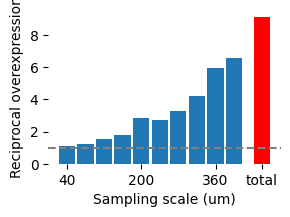

In [92]:
fig = plt.figure(figsize=(3, 2.0))
ax = fig.gca()

x = all_P.index.to_frame()["scale"].values
x_extra = x[-1] + 1.5 * numpy.mean(numpy.diff(x))
ax.bar(x, all_P['reciprocal'] / (all_P['unidirectional'] ** 2), width=35)
ax.bar(x_extra, P_rec_ttl / (P_uni_ttl ** 2), width=35, color="red")
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1, 1], color="grey", ls="--")
ticks = x[::4]
ax.set_xticks(list(ticks) + [x_extra])
ax.set_xticklabels(list(ticks) + ["total"])
ax.set_xlabel("Sampling scale (um)")
ax.set_ylabel("Reciprocal overexpression")
ax.set_frame_on(False)

#### Part IIa: Triad motifs at different scales

Text(0, 0.5, 'Sampling scale(um)')

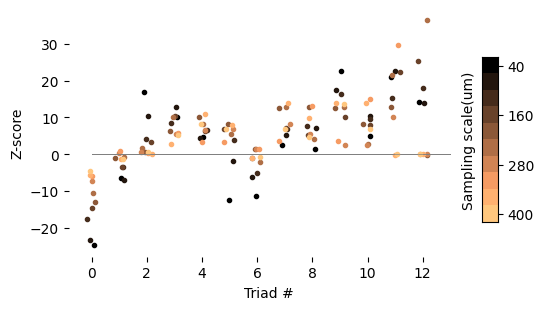

In [123]:
from matplotlib import cm
fig = plt.figure(figsize=(5, 2.75))
ax = fig.add_axes([0.025, 0.025, 0.8, 0.9])

lvls = all_counts.index.levels[0]
cols = cm.copper(numpy.linspace(0, 1, len(lvls)))

for lvl, col in zip(lvls, cols):
    x = all_counts.columns + 0.4 * (numpy.random.rand(len(all_counts.columns)) - 0.5)
    ax.plot(x, all_counts.loc[lvl].mean(), color=col, ls="None", marker='o', ms=3)
    ax.plot([0, 13], [0, 0], color="grey", lw=0.5)
ax.set_frame_on(False)
ax.set_xlabel("Triad #")
ax.set_ylabel("Z-score")

ax = fig.add_axes([0.85, 0.15, 0.035, 0.6])
c = cols.reshape((-1, 1, 4))
ax.imshow(c)
ax.set_xticks([]); ax.yaxis.tick_right()
ticks = numpy.arange(0, len(lvls), 3)
ax.set_yticks(ticks)
ax.set_yticklabels(lvls.values[ticks])
ax.set_ylabel("Sampling scale(um)")